In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

In [3]:
train=pd.read_csv('/content/drive/My Drive/Data Science/NLP_FLIPROBO_1/train.csv')

In [5]:
train.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy


In [4]:
test=pd.read_csv('/content/drive/My Drive/Data Science/NLP_FLIPROBO_1/test.csv')

In [7]:
test.head()

,User_ID,Description,Browser_Used,Device_Used
0,id80132,Looking for a motel in close proximity to TV t...,Firefox,Mobile
1,id80133,Walking distance to Madison Square Garden and ...,InternetExplorer,Desktop
2,id80134,Visited Seattle on business. Spent - nights in...,IE,Tablet
3,id80135,This hotel location is excellent and the rooms...,Edge,Mobile
4,id80136,This hotel is awesome I love the service Antho...,Mozilla,Mobile


In [91]:
train['Browser_Used'].value_counts()

Firefox              7367
Edge                 7134
Google Chrome        4659
InternetExplorer     4588
Mozilla Firefox      4328
Mozilla              3092
Chrome               2470
IE                   2439
Internet Explorer    2103
Safari                390
Opera                 362
Name: Browser_Used, dtype: int64

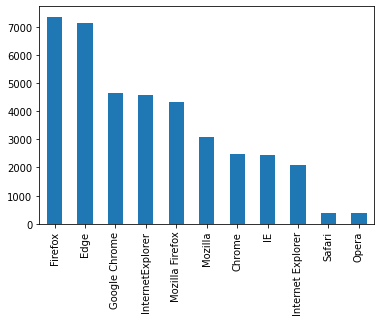

In [92]:
train['Browser_Used'].value_counts().plot.bar()

In [94]:
train['Device_Used'].value_counts()

Desktop    15026
Mobile     14976
Tablet      8930
Name: Device_Used, dtype: int64

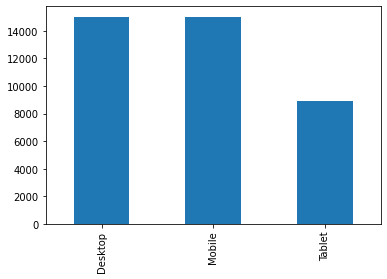

In [95]:
train['Device_Used'].value_counts().plot.bar()

In [96]:
train['Is_Response'].value_counts()

happy        26521
not happy    12411
Name: Is_Response, dtype: int64

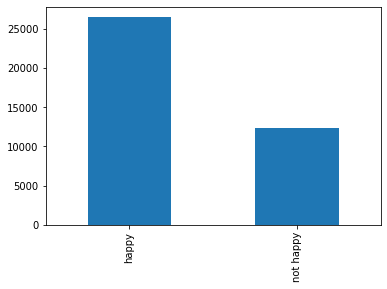

In [97]:
train['Is_Response'].value_counts().plot.bar()

In [5]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from tqdm import tqdm
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
stopword=stopwords.words('english')
stopword=[word for word in stopword if word not in ['no','nor','not']]
stopword.extend(["youre", "youve", "youll", "youd", "shes", "thatll","dont", "shouldve",'should\'t','should','ain', 'aren', "arent", 'couldn', "couldnt", 'didn', "didnt", 'doesn', "doesnt", 'hadn',\
            "hadnt", 'hasn', "hasnt", 'haven', "havent", 'isn', "isnt", 'ma', 'mightn', "mightnt", 'mustn',\
            "mustnt", 'needn', "neednt", 'shan', "shant", 'shouldn', "shouldnt", 'wasn', "wasnt", 'weren', "werent", \
            'won', "wont", 'wouldn', "wouldnt",'might','must','could','would','willnt','will\'nt','will not','will'])

In [9]:
stopword=set(stopword)

In [13]:
len(stopword)

209

In [10]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [11]:
def text_cleaning(sent):
  sent=decontracted(sent)
  sent=re.sub(r"http\S+", "", sent)
  sent = re.sub("\S*\d\S*", "", sent)
  sent=re.sub('[^A-Za-z0-9]+', ' ', sent)
  sent=sent.lower()
  lemma = WordNetLemmatizer()
  porter = PorterStemmer()
  sent = ' '.join(lemma.lemmatize(e,pos='v') for e in sent.split() if e not in stopword)
  sent=sent.translate(str.maketrans('', '', string.punctuation))

  return sent

In [12]:
train['cleaned']=train['Description'].apply(text_cleaning)

In [17]:
train.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response,cleaned
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy,room kind clean strong smell dog generally ave...
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy,stay crown plaza april april staff friendly at...
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy,book hotel hotwire lowest price find get front...
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy,stay husband sons way alaska cruise love hotel...
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy,girlfriends stay celebrate th birthdays plan w...


In [13]:
def num_words(sent):
  return(len(sent))

In [14]:
train['words in Description']=train['Description'].apply(num_words)
train['words in cleaned']=train['cleaned'].apply(num_words)

In [20]:
train.head(10)

,User_ID,Description,Browser_Used,Device_Used,Is_Response,cleaned,words in Description,words in cleaned
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy,room kind clean strong smell dog generally ave...,248,134
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy,stay crown plaza april april staff friendly at...,1077,619
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy,book hotel hotwire lowest price find get front...,1327,772
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy,stay husband sons way alaska cruise love hotel...,502,312
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy,girlfriends stay celebrate th birthdays plan w...,1613,888
5,id10331,We had - rooms. One was very nice and clearly ...,InternetExplorer,Desktop,happy,room one nice clearly update recently clean be...,610,350
6,id10332,My husband and I have stayed in this hotel a f...,Firefox,Tablet,not happy,husband stay hotel time though not fanciest ho...,492,247
7,id10333,My wife & I stayed in this glorious city a whi...,Google Chrome,Mobile,happy,wife stay glorious city back sf expensive find...,935,576
8,id10334,My boyfriend and I stayed at the Fairmont on a...,Internet Explorer,Desktop,happy,boyfriend stay fairmont recent trip san franci...,639,389
9,id10335,"Wonderful staff, great location, but it was de...",Chrome,Tablet,not happy,wonderful staff great location definately pric...,358,255


In [21]:
train.shape

(38932, 8)

In [78]:
cleaned=train['cleaned'].values

In [16]:
count=CountVectorizer(max_features=500)
bow=count.fit_transform(cleaned)

In [24]:
bow

<38932x500 sparse matrix of type '<class 'numpy.int64'>'
	with 1611820 stored elements in Compressed Sparse Row format>

In [25]:
bow.get_shape()

(38932, 500)

In [19]:
bow_feat=pd.DataFrame.sparse.from_spmatrix(bow)
bow_feat.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,2,1,...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


In [27]:
len(count.get_feature_names())

500

In [20]:
bow_feat.columns=count.get_feature_names()

In [21]:
bow_feat.head()

,able,absolutely,access,accommodate,across,actually,add,air,airport,allow,almost,along,also,although,always,amaze,amenities,another,anyone,anything,anywhere,area,areas,around,arrival,arrive,ask,attractions,available,average,away,awesome,back,bad,bag,bar,base,bath,bathroom,bathrooms,...,two,union,update,upgrade,upon,us,use,valet,value,view,visit,wait,walk,wall,want,warm,watch,water,way,week,weekend,welcome,well,westin,whole,wife,wifi,window,windows,wine,within,without,wonderful,work,world,worth,year,years,yes,york
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,2,1,...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


In [22]:
bow_df=pd.concat([train,bow_feat],axis=1)

In [31]:
bow_df.shape

(38932, 508)

In [23]:
bow_df.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response,cleaned,words in Description,words in cleaned,able,absolutely,access,accommodate,across,actually,add,air,airport,allow,almost,along,also,although,always,amaze,amenities,another,anyone,anything,anywhere,area,areas,around,arrival,arrive,ask,attractions,available,average,away,awesome,...,two,union,update,upgrade,upon,us,use,valet,value,view,visit,wait,walk,wall,want,warm,watch,water,way,week,weekend,welcome,well,westin,whole,wife,wifi,window,windows,wine,within,without,wonderful,work,world,worth,year,years,yes,york
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy,room kind clean strong smell dog generally ave...,248,134,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy,stay crown plaza april april staff friendly at...,1077,619,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy,book hotel hotwire lowest price find get front...,1327,772,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy,stay husband sons way alaska cruise love hotel...,502,312,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy,girlfriends stay celebrate th birthdays plan w...,1613,888,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


In [24]:
bow_df.drop(['User_ID','Description','cleaned','words in Description'],axis=1,inplace=True)

In [34]:
bow_df.head(1)

,Browser_Used,Device_Used,Is_Response,words in cleaned,able,absolutely,access,accommodate,across,actually,add,air,airport,allow,almost,along,also,although,always,amaze,amenities,another,anyone,anything,anywhere,area,areas,around,arrival,arrive,ask,attractions,available,average,away,awesome,back,bad,bag,bar,...,two,union,update,upgrade,upon,us,use,valet,value,view,visit,wait,walk,wall,want,warm,watch,water,way,week,weekend,welcome,well,westin,whole,wife,wifi,window,windows,wine,within,without,wonderful,work,world,worth,year,years,yes,york
0,Edge,Mobile,not happy,134,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
count=CountVectorizer(max_features=500)
bow=count.fit_transform(cleaned)
bow_feat=pd.DataFrame.sparse.from_spmatrix(bow)
bow_feat.columns=count.get_feature_names()
bow_1000=pd.concat([train,bow_feat],axis=1)
bow_1000.drop(['User_ID','Description','cleaned','words in Description'],axis=1,inplace=True)
bow_1000['Browser_Used']=bow_1000['Browser_Used'].map({'Google Chrome':'Chrome','InternetExplorer':'IE', 'Internet Explorer':'IE', 'Mozilla Firefox':'Firefox',
                                                 'Mozilla':'Firefox', 'Safari':'Safari','Opera':'Opera','Edge':'Edge','Chrome':'Chrome',
                                            'Firefox':'Firefox','IE':'IE'})
browser=pd.get_dummies(bow_1000['Browser_Used'],drop_first=True)
bow_1000=pd.concat([browser,bow_1000],axis=1)
device=pd.get_dummies(bow_1000['Device_Used'],drop_first=True)
bow_1000=pd.concat([device,bow_1000],axis=1)
bow_1000.drop(['Browser_Used','Device_Used'],axis=1,inplace=True)
bow_1000['Is_Response']=bow_1000['Is_Response'].map({'not happy':0, 'happy':1})
bow_1000.head()

,Mobile,Tablet,Edge,Firefox,IE,Opera,Safari,Is_Response,words in cleaned,able,absolutely,access,accommodate,across,actually,add,air,airport,allow,almost,along,also,although,always,amaze,amenities,another,anyone,anything,anywhere,area,areas,around,arrival,arrive,ask,attractions,available,average,away,...,two,union,update,upgrade,upon,us,use,valet,value,view,visit,wait,walk,wall,want,warm,watch,water,way,week,weekend,welcome,well,westin,whole,wife,wifi,window,windows,wine,within,without,wonderful,work,world,worth,year,years,yes,york
0,1,0,1,0,0,0,0,0,134,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,619,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,772,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,1,312,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,0,0,0,0,888,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


In [39]:
x=bow_1000.drop(['Is_Response'],axis=1)
y=bow_1000['Is_Response']
x_train,x_te,y_train,y_te=train_test_split(x,y,test_size=0.15,random_state=50,stratify=y)
x_tr,x_cv,y_tr,y_cv=train_test_split(x_train,y_train,test_size=0.20,random_state=50,stratify=y_train)
gnb=GaussianNB()
get_score(gnb,x_tr,y_tr,x_cv,y_cv)

(0.7831753106939146, 0.7839552802538148, 0.8469933661459448)

38932

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,precision_score,f1_score,recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score,cross_val_predict,cross_validate
from sklearn.metrics import roc_curve, roc_auc_score
gnb=GaussianNB()

In [27]:
def get_score(m,x_tr,y_tr,x_cv,y_cv):
    m.fit(x_tr,y_tr)
    train_score=m.score(x_tr,y_tr)
    pred=m.predict(x_cv)
    acc=accuracy_score(pred,y_cv)
    f=f1_score(pred,y_cv)
    return train_score,acc,f

In [40]:
# No underfitting or over fitting

In [41]:
# Lets try and take 1000 features

In [28]:
count=CountVectorizer(max_features=1000)
bow=count.fit_transform(cleaned)
bow_feat=pd.DataFrame.sparse.from_spmatrix(bow)
bow_feat.columns=count.get_feature_names()
bow_1000=pd.concat([train,bow_feat],axis=1)
bow_1000.drop(['User_ID','Description','cleaned','words in Description'],axis=1,inplace=True)
bow_1000['Browser_Used']=bow_1000['Browser_Used'].map({'Google Chrome':'Chrome','InternetExplorer':'IE', 'Internet Explorer':'IE', 'Mozilla Firefox':'Firefox',
                                                 'Mozilla':'Firefox', 'Safari':'Safari','Opera':'Opera','Edge':'Edge','Chrome':'Chrome',
                                            'Firefox':'Firefox','IE':'IE'})
browser=pd.get_dummies(bow_1000['Browser_Used'],drop_first=True)
bow_1000=pd.concat([browser,bow_1000],axis=1)
device=pd.get_dummies(bow_1000['Device_Used'],drop_first=True)
bow_1000=pd.concat([device,bow_1000],axis=1)
bow_1000.drop(['Browser_Used','Device_Used'],axis=1,inplace=True)
bow_1000['Is_Response']=bow_1000['Is_Response'].map({'not happy':0, 'happy':1})
bow_1000.head()

,Mobile,Tablet,Edge,Firefox,IE,Opera,Safari,Is_Response,words in cleaned,able,absolutely,ac,access,accommodate,accomodating,across,actually,add,addition,additional,adequate,adults,advance,advantage,advise,afternoon,age,ago,agree,air,airport,allow,almost,alone,along,already,also,although,always,amaze,...,weather,website,wed,week,weekend,weeks,welcome,well,west,westin,wharf,white,whole,wi,wife,wifi,window,windows,wine,wireless,wish,within,without,woman,wonderful,word,work,world,worry,worse,worst,worth,write,wrong,year,years,yes,yet,york,young
0,1,0,1,0,0,0,0,0,134,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,619,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,772,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,1,312,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,0,0,0,0,888,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [29]:
x=bow_1000.drop(['Is_Response'],axis=1)
y=bow_1000['Is_Response']
x_train,x_te,y_train,y_te=train_test_split(x,y,test_size=0.15,random_state=50,stratify=y)
x_tr,x_cv,y_tr,y_cv=train_test_split(x_train,y_train,test_size=0.20,random_state=50,stratify=y_train)
get_score(gnb,x_tr,y_tr,x_cv,y_cv)

(0.7999471159294376, 0.7981568212720955, 0.8550661748752441)

In [155]:
count=CountVectorizer(max_features=5000)
bow=count.fit_transform(cleaned)
bow_feat=pd.DataFrame.sparse.from_spmatrix(bow)
bow_feat.columns=count.get_feature_names()
bow_5000=pd.concat([train,bow_feat],axis=1)
bow_5000.drop(['User_ID','Description','cleaned','words in Description'],axis=1,inplace=True)
bow_5000['Browser_Used']=bow_5000['Browser_Used'].map({'Google Chrome':'Chrome','InternetExplorer':'IE', 'Internet Explorer':'IE', 'Mozilla Firefox':'Firefox',
                                                 'Mozilla':'Firefox', 'Safari':'Safari','Opera':'Opera','Edge':'Edge','Chrome':'Chrome',
                                            'Firefox':'Firefox','IE':'IE'})
browser=pd.get_dummies(bow_5000['Browser_Used'],drop_first=True)
bow_5000=pd.concat([browser,bow_5000],axis=1)
device=pd.get_dummies(bow_5000['Device_Used'],drop_first=True)
bow_5000=pd.concat([device,bow_5000],axis=1)
bow_5000.drop(['Browser_Used','Device_Used'],axis=1,inplace=True)
bow_5000['Is_Response']=bow_5000['Is_Response'].map({'not happy':0, 'happy':1})
bow_5000.head()

,Mobile,Tablet,Edge,Firefox,IE,Opera,Safari,Is_Response,words in cleaned,aaa,abandon,ability,able,abound,abrupt,absence,absolute,absolutely,abundance,abundant,ac,accent,accept,acceptable,access,accessible,accident,accidentally,accomadating,accommodate,accommodation,accommodations,accomodate,accomodated,accomodating,accomodation,accomodations,accompany,accord,accordingly,...,wrong,ws,wtc,wyndham,xmas,xv,ya,yard,yards,yeah,year,years,yell,yellow,yes,yesterday,yet,ymca,yo,yoga,yoghurt,yogurt,yogurts,york,yorker,yorkers,yotel,young,younger,youth,yr,yrs,yuck,yum,yummy,zaza,zen,zero,zone,zoo
0,1,0,1,0,0,0,0,0,134,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,619,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,772,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,1,312,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,0,0,0,0,888,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [156]:
x=bow_5000.drop(['Is_Response'],axis=1)
y=bow_5000['Is_Response']
x_train,x_te,y_train,y_te=train_test_split(x,y,test_size=0.15,random_state=50,stratify=y)
x_tr,x_cv,y_tr,y_cv=train_test_split(x_train,y_train,test_size=0.20,random_state=50,stratify=y_train)
get_score(gnb,x_tr,y_tr,x_cv,y_cv)

(0.8207607751293771, 0.7933222541169361, 0.8513366659421866)

In [157]:
count=CountVectorizer(max_features=10000)
bow=count.fit_transform(cleaned)
bow_feat=pd.DataFrame.sparse.from_spmatrix(bow)
bow_feat.columns=count.get_feature_names()
bow_1000=pd.concat([train,bow_feat],axis=1)
bow_1000.drop(['User_ID','Description','cleaned','words in Description'],axis=1,inplace=True)
bow_1000['Browser_Used']=bow_1000['Browser_Used'].map({'Google Chrome':'Chrome','InternetExplorer':'IE', 'Internet Explorer':'IE', 'Mozilla Firefox':'Firefox',
                                                 'Mozilla':'Firefox', 'Safari':'Safari','Opera':'Opera','Edge':'Edge','Chrome':'Chrome',
                                            'Firefox':'Firefox','IE':'IE'})
browser=pd.get_dummies(bow_1000['Browser_Used'],drop_first=True)
bow_1000=pd.concat([browser,bow_1000],axis=1)
device=pd.get_dummies(bow_1000['Device_Used'],drop_first=True)
bow_1000=pd.concat([device,bow_1000],axis=1)
bow_1000.drop(['Browser_Used','Device_Used'],axis=1,inplace=True)
bow_1000['Is_Response']=bow_1000['Is_Response'].map({'not happy':0, 'happy':1})
bow_1000.head()

,Mobile,Tablet,Edge,Firefox,IE,Opera,Safari,Is_Response,words in cleaned,aa,aaa,aarp,aback,abandon,abc,abide,ability,abit,able,abound,abrasive,abri,abroad,abrupt,abruptly,absence,absent,absolute,absolutely,absolutley,absolutly,absorb,absorbent,absurd,absurdly,abt,abundance,abundant,abuse,abut,...,yikes,ymca,yo,yoga,yoghurt,yoghurts,yogurt,yogurts,yolk,york,yorker,yorkers,yosemite,yotel,young,younger,youngest,youth,youthful,yr,yrs,yuck,yucky,yuk,yum,yummy,yup,zabar,zabars,zagat,zaza,zealand,zebra,zen,zero,zip,zipper,zocca,zone,zoo
0,1,0,1,0,0,0,0,0,134,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,619,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,772,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,1,312,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,0,0,0,0,888,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [158]:
x=bow_1000.drop(['Is_Response'],axis=1)
y=bow_1000['Is_Response']
x_train,x_te,y_train,y_te=train_test_split(x,y,test_size=0.15,random_state=50,stratify=y)
x_tr,x_cv,y_tr,y_cv=train_test_split(x_train,y_train,test_size=0.20,random_state=50,stratify=y_train)
get_score(gnb,x_tr,y_tr,x_cv,y_cv)

(0.8434253767990028, 0.786674724278592, 0.8471861471861473)

In [160]:
count=CountVectorizer(max_features=5000, binary=True)
bow=count.fit_transform(cleaned)
bow_feat=pd.DataFrame.sparse.from_spmatrix(bow)
bow_feat.columns=count.get_feature_names()
bow_1000=pd.concat([train,bow_feat],axis=1)
bow_1000.drop(['User_ID','Description','cleaned','words in Description'],axis=1,inplace=True)
bow_1000['Browser_Used']=bow_1000['Browser_Used'].map({'Google Chrome':'Chrome','InternetExplorer':'IE', 'Internet Explorer':'IE', 'Mozilla Firefox':'Firefox',
                                                 'Mozilla':'Firefox', 'Safari':'Safari','Opera':'Opera','Edge':'Edge','Chrome':'Chrome',
                                            'Firefox':'Firefox','IE':'IE'})
browser=pd.get_dummies(bow_1000['Browser_Used'],drop_first=True)
bow_1000=pd.concat([browser,bow_1000],axis=1)
device=pd.get_dummies(bow_1000['Device_Used'],drop_first=True)
bow_1000=pd.concat([device,bow_1000],axis=1)
bow_1000.drop(['Browser_Used','Device_Used'],axis=1,inplace=True)
bow_1000['Is_Response']=bow_1000['Is_Response'].map({'not happy':0, 'happy':1})
bow_1000.head()

,Mobile,Tablet,Edge,Firefox,IE,Opera,Safari,Is_Response,words in cleaned,aaa,abandon,ability,able,abound,abrupt,absence,absolute,absolutely,absurd,abundance,abundant,ac,accent,accept,acceptable,access,accessible,accident,accidentally,accomadating,accommodate,accommodation,accommodations,accomodate,accomodated,accomodating,accomodation,accomodations,accompany,accord,...,write,wrong,ws,wtc,wyndham,xmas,ya,yard,yards,yeah,year,years,yell,yellow,yes,yesterday,yet,yo,yoga,yoghurt,yogurt,yogurts,york,yorker,yorkers,yotel,young,younger,youth,yr,yrs,yuck,yum,yummy,zaza,zen,zero,zip,zone,zoo
0,1,0,1,0,0,0,0,0,134,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,619,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,772,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,1,312,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,0,0,0,0,888,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [161]:
x=bow_1000.drop(['Is_Response'],axis=1)
y=bow_1000['Is_Response']
x_train,x_te,y_train,y_te=train_test_split(x,y,test_size=0.15,random_state=50,stratify=y)
x_tr,x_cv,y_tr,y_cv=train_test_split(x_train,y_train,test_size=0.20,random_state=50,stratify=y_train)
get_score(gnb,x_tr,y_tr,x_cv,y_cv)

(0.8283156423525857, 0.806315153346427, 0.8589038080563504)

In [162]:
# Now lets try TF-IDF

In [34]:
count=TfidfVectorizer(max_features=1000)
bow=count.fit_transform(cleaned)
bow_feat=pd.DataFrame.sparse.from_spmatrix(bow)
bow_feat.columns=count.get_feature_names()
bow_1000=pd.concat([train,bow_feat],axis=1)
bow_1000.drop(['User_ID','Description','cleaned','words in Description'],axis=1,inplace=True)
bow_1000['Browser_Used']=bow_1000['Browser_Used'].map({'Google Chrome':'Chrome','InternetExplorer':'IE', 'Internet Explorer':'IE', 'Mozilla Firefox':'Firefox',
                                                 'Mozilla':'Firefox', 'Safari':'Safari','Opera':'Opera','Edge':'Edge','Chrome':'Chrome',
                                            'Firefox':'Firefox','IE':'IE'})
browser=pd.get_dummies(bow_1000['Browser_Used'],drop_first=True)
bow_1000=pd.concat([browser,bow_1000],axis=1)
device=pd.get_dummies(bow_1000['Device_Used'],drop_first=True)
bow_1000=pd.concat([device,bow_1000],axis=1)
bow_1000.drop(['Browser_Used','Device_Used'],axis=1,inplace=True)
bow_1000['Is_Response']=bow_1000['Is_Response'].map({'not happy':0, 'happy':1})
bow_1000.head()

,Mobile,Tablet,Edge,Firefox,IE,Opera,Safari,Is_Response,words in cleaned,able,absolutely,ac,access,accommodate,accomodating,across,actually,add,addition,additional,adequate,adults,advance,advantage,advise,afternoon,age,ago,agree,air,airport,allow,almost,alone,along,already,also,although,always,amaze,...,weather,website,wed,week,weekend,weeks,welcome,well,west,westin,wharf,white,whole,wi,wife,wifi,window,windows,wine,wireless,wish,within,without,woman,wonderful,word,work,world,worry,worse,worst,worth,write,wrong,year,years,yes,yet,york,young
0,1,0,1,0,0,0,0,0,134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0,0,1,0,0,0,619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.071924,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,0,1,0,0,0,0,772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.11522,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,1,0,0,1,312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.151498,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.179111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1,1,0,0,0,0,0,888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.072987,0.0,0.0,0.052555,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071764,0.0,0.000000,0.0,0.0,0.0,0.0,0.080207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [164]:
x=bow_1000.drop(['Is_Response'],axis=1)
y=bow_1000['Is_Response']
x_train,x_te,y_train,y_te=train_test_split(x,y,test_size=0.15,random_state=50,stratify=y)
x_tr,x_cv,y_tr,y_cv=train_test_split(x_train,y_train,test_size=0.20,random_state=50,stratify=y_train)
get_score(gnb,x_tr,y_tr,x_cv,y_cv)

(0.8318286556113776, 0.8262577428614595, 0.8670520231213873)

In [29]:
count=TfidfVectorizer(max_features=5000)
bow=count.fit_transform(cleaned)
bow_feat=pd.DataFrame.sparse.from_spmatrix(bow)
bow_feat.columns=count.get_feature_names()
bow_1000=pd.concat([train,bow_feat],axis=1)
bow_1000.drop(['User_ID','Description','cleaned','words in Description'],axis=1,inplace=True)
bow_1000['Browser_Used']=bow_1000['Browser_Used'].map({'Google Chrome':'Chrome','InternetExplorer':'IE', 'Internet Explorer':'IE', 'Mozilla Firefox':'Firefox',
                                                 'Mozilla':'Firefox', 'Safari':'Safari','Opera':'Opera','Edge':'Edge','Chrome':'Chrome',
                                            'Firefox':'Firefox','IE':'IE'})
browser=pd.get_dummies(bow_1000['Browser_Used'],drop_first=True)
bow_1000=pd.concat([browser,bow_1000],axis=1)
device=pd.get_dummies(bow_1000['Device_Used'],drop_first=True)
bow_1000=pd.concat([device,bow_1000],axis=1)
bow_1000.drop(['Browser_Used','Device_Used'],axis=1,inplace=True)
bow_1000['Is_Response']=bow_1000['Is_Response'].map({'not happy':0, 'happy':1})
bow_1000.head()

,Mobile,Tablet,Edge,Firefox,IE,Opera,Safari,Is_Response,words in cleaned,aaa,abandon,ability,able,abound,abrupt,absence,absolute,absolutely,abundance,abundant,ac,accent,accept,acceptable,access,accessible,accident,accidentally,accomadating,accommodate,accommodation,accommodations,accomodate,accomodated,accomodating,accomodation,accomodations,accompany,accord,accordingly,...,wrong,ws,wtc,wyndham,xmas,xv,ya,yard,yards,yeah,year,years,yell,yellow,yes,yesterday,yet,ymca,yo,yoga,yoghurt,yogurt,yogurts,york,yorker,yorkers,yotel,young,younger,youth,yr,yrs,yuck,yum,yummy,zaza,zen,zero,zone,zoo
0,1,0,1,0,0,0,0,0,134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0,0,1,0,0,0,619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,0,1,0,0,0,0,772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,1,0,0,1,312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1,1,0,0,0,0,0,888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
x=bow_1000.drop(['Is_Response'],axis=1)
y=bow_1000['Is_Response']
x_train,x_te,y_train,y_te=train_test_split(x,y,test_size=0.15,random_state=50,stratify=y)
x_tr,x_cv,y_tr,y_cv=train_test_split(x_train,y_train,test_size=0.20,random_state=50,stratify=y_train)
get_score(gnb,x_tr,y_tr,x_cv,y_cv)

(0.8620481245042119, 0.8474089741652817, 0.8864658273381296)

In [44]:
count=TfidfVectorizer(max_features=10000)
bow=count.fit_transform(cleaned)
bow_feat=pd.DataFrame.sparse.from_spmatrix(bow)
bow_feat.columns=count.get_feature_names()
bow_1000=pd.concat([train,bow_feat],axis=1)
bow_1000.drop(['User_ID','Description','cleaned','words in Description'],axis=1,inplace=True)
bow_1000['Browser_Used']=bow_1000['Browser_Used'].map({'Google Chrome':'Chrome','InternetExplorer':'IE', 'Internet Explorer':'IE', 'Mozilla Firefox':'Firefox',
                                                 'Mozilla':'Firefox', 'Safari':'Safari','Opera':'Opera','Edge':'Edge','Chrome':'Chrome',
                                            'Firefox':'Firefox','IE':'IE'})
browser=pd.get_dummies(bow_1000['Browser_Used'],drop_first=True)
bow_1000=pd.concat([browser,bow_1000],axis=1)
device=pd.get_dummies(bow_1000['Device_Used'],drop_first=True)
bow_1000=pd.concat([device,bow_1000],axis=1)
bow_1000.drop(['Browser_Used','Device_Used'],axis=1,inplace=True)
bow_1000['Is_Response']=bow_1000['Is_Response'].map({'not happy':0, 'happy':1})
bow_1000.head()

,Mobile,Tablet,Edge,Firefox,IE,Opera,Safari,Is_Response,words in cleaned,aa,aaa,aarp,aback,abandon,abc,abide,ability,abit,able,abound,abrasive,abri,abroad,abrupt,abruptly,absence,absent,absolute,absolutely,absolutley,absolutly,absorb,absorbent,absurd,absurdly,abt,abundance,abundant,abuse,abut,...,yikes,ymca,yo,yoga,yoghurt,yoghurts,yogurt,yogurts,yolk,york,yorker,yorkers,yosemite,yotel,young,younger,youngest,youth,youthful,yr,yrs,yuck,yucky,yuk,yum,yummy,yup,zabar,zabars,zagat,zaza,zealand,zebra,zen,zero,zip,zipper,zocca,zone,zoo
0,1,0,1,0,0,0,0,0,134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0,0,1,0,0,0,619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,0,1,0,0,0,0,772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,1,0,0,1,312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1,1,0,0,0,0,0,888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
x=bow_1000.drop(['Is_Response'],axis=1)
y=bow_1000['Is_Response']
x_train,x_te,y_train,y_te=train_test_split(x,y,test_size=0.15,random_state=50,stratify=y)
x_tr,x_cv,y_tr,y_cv=train_test_split(x_train,y_train,test_size=0.20,random_state=50,stratify=y_train)
get_score(gnb,x_tr,y_tr,x_cv,y_cv)

(0.8739848147168814, 0.8525457017676387, 0.8910714285714286)

In [46]:
# Lets try word2vec now

In [30]:
from gensim.models import Word2Vec

In [31]:
list_sent=[]
for sentance in cleaned:
    list_sent.append(sentance.split())

In [32]:
w2v=Word2Vec(list_sent,min_count=5,size=100, workers=4)

In [33]:
w2v_words = list(w2v.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  11896


In [35]:
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_sent): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 38932/38932 [01:09<00:00, 563.11it/s]

38932
100


In [1]:
# sent_vectors

In [37]:
word_vec=pd.DataFrame(sent_vectors)
word_vec.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,-0.138966,0.080446,-0.108662,-0.545590,-0.330953,-0.150485,-0.596001,0.509425,0.557236,0.171407,0.746096,0.467488,0.659587,0.794608,0.393952,0.126474,-0.074344,-0.151973,-0.069471,0.925523,0.379582,0.244921,-0.401245,-0.749464,-0.306772,0.190665,-0.279759,0.780746,0.451256,0.054982,-0.079135,-0.795568,-0.154776,0.031769,0.103220,-0.225633,-0.253052,0.651846,0.027564,0.094534,...,0.601428,0.634378,0.262960,-0.177215,-0.053250,0.277392,0.318722,-0.063949,-0.794294,-0.070699,0.108365,0.482707,0.438151,0.132097,-0.006171,0.153073,0.199047,-0.381862,0.008557,-0.314475,-0.475855,-0.166388,0.497106,-0.001995,-0.314925,-0.360728,0.134632,-0.532840,0.308111,-0.394748,-0.090518,0.013814,-0.702845,0.319978,0.236400,0.626269,-0.263728,0.493713,0.405779,0.023530
1,-0.257983,-0.363556,-0.257907,-0.316526,-0.108457,-0.070441,-0.296333,0.255484,0.276875,0.353478,-0.091244,0.346044,0.282643,0.114388,0.165926,-0.112085,0.403104,0.366731,-0.197296,0.332828,0.315146,0.242952,-0.313821,-0.398785,-0.059310,0.303321,-0.601344,0.231465,0.378559,0.276177,-0.026753,-0.074704,-0.023541,-0.374555,0.164772,0.137093,0.227160,0.975417,0.001802,0.396257,...,-0.009859,-0.392400,0.077226,-0.366743,0.172416,-0.185783,-0.025525,-0.108940,-0.602835,0.090801,0.260080,0.032210,0.154028,-0.114215,-0.312555,0.530268,-0.175262,-0.315314,-0.360916,-0.265181,-0.064120,0.208000,0.064147,0.095877,-0.281611,-0.509428,0.122797,-0.238447,-0.263897,-0.344534,-0.170280,0.469755,0.071863,0.412291,0.639401,0.507088,-0.249365,0.391344,0.193961,0.191482
2,-0.275953,-0.000964,-0.410956,-0.461517,-0.246950,-0.355500,-0.313614,0.400715,0.563100,0.400851,0.375843,0.313188,0.449006,0.579830,0.323648,-0.106962,0.277990,0.401233,-0.032954,0.687006,0.406272,0.308652,-0.610746,-0.414717,-0.112511,0.101806,-0.257082,-0.192843,0.338354,-0.171880,-0.127711,-0.719189,-0.424156,-0.007510,0.110022,0.002301,0.318137,0.563839,-0.059949,0.142864,...,0.057455,-0.138163,0.289050,-0.176165,0.040941,0.008074,0.158894,-0.074244,-0.623235,0.365255,0.280735,0.469153,0.284552,-0.150141,-0.221286,0.213950,-0.215405,-0.453962,0.045013,-0.487127,-0.173746,0.033640,0.103905,0.103303,-0.229562,-0.187163,0.099476,-0.036653,-0.210204,-0.341797,-0.298814,0.055112,-0.148769,0.504988,0.584414,0.571649,0.194135,0.245057,0.400719,0.112250
3,-0.581902,0.029044,-0.244438,-0.066860,-0.225113,-0.046214,-0.648334,0.300296,-0.187904,-0.036655,0.104684,0.638273,0.212802,0.501280,-0.337009,0.032916,0.166131,-0.302808,0.465551,-0.245901,0.121508,-0.234439,0.095980,-0.408774,0.509631,0.098293,-0.140333,-0.456892,0.056906,0.014309,-0.285253,-0.300740,0.124669,-0.226175,0.306385,0.284436,0.494167,0.505811,-0.326375,0.314523,...,-0.464323,-0.285887,0.012991,-0.212275,0.366319,0.002525,0.215387,-1.126979,-0.412002,0.008712,0.319169,0.349423,-0.430364,-0.567400,0.016606,0.092003,0.003439,0.084960,0.460295,0.203813,0.172473,0.341026,0.095946,0.027952,0.096495,0.501089,-0.141033,-0.302864,-0.284100,-0.875723,0.006501,-0.358741,-0.549251,-0.167976,0.580888,0.474852,0.223085,0.329487,0.288913,-0.386460
4,-0.051635,-0.080530,-0.148931,-0.247862,-0.145329,0.176890,-0.771289,0.345857,0.221411,0.177571,0.361307,0.316001,0.700348,-0.052365,-0.294426,0.263482,-0.176087,-0.106631,-0.347152,0.566504,-0.260888,0.077279,-0.189244,-0.433984,-0.097118,0.298459,-0.005709,0.288840,0.267353,-0.306397,-0.214009,-0.002994,-0.111642,0.424763,0.185366,0.307499,0.101429,0.286156,0.187893,0.205973,...,-0.157328,-0.040437,0.446998,-0.424972,0.071084,0.098850,-0.196845,-0.210299,-0.339940,0.584962,0.282597,0.747540,0.338016,-0.274942,-0.088961,0.478415,-0.353170,0.132301,-0.370537,-0.694064,0.235742,-0.096216,-0.095917,-0.400080,-0.077013,-0.067686,0.571891,-0.307356,0.321021,-0.535672,0.048604,-0.100060,-0.337905,-0.087047,0.

In [38]:
word_vec.shape

(38932, 100)

In [39]:
word_vec_df=pd.concat([train,word_vec],axis=1)

In [40]:
word_vec_df.drop(['User_ID','Description','cleaned','words in Description'],axis=1,inplace=True)
word_vec_df.head()

,Browser_Used,Device_Used,Is_Response,words in cleaned,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,Edge,Mobile,not happy,134,-0.138966,0.080446,-0.108662,-0.545590,-0.330953,-0.150485,-0.596001,0.509425,0.557236,0.171407,0.746096,0.467488,0.659587,0.794608,0.393952,0.126474,-0.074344,-0.151973,-0.069471,0.925523,0.379582,0.244921,-0.401245,-0.749464,-0.306772,0.190665,-0.279759,0.780746,0.451256,0.054982,-0.079135,-0.795568,-0.154776,0.031769,0.103220,-0.225633,...,0.601428,0.634378,0.262960,-0.177215,-0.053250,0.277392,0.318722,-0.063949,-0.794294,-0.070699,0.108365,0.482707,0.438151,0.132097,-0.006171,0.153073,0.199047,-0.381862,0.008557,-0.314475,-0.475855,-0.166388,0.497106,-0.001995,-0.314925,-0.360728,0.134632,-0.532840,0.308111,-0.394748,-0.090518,0.013814,-0.702845,0.319978,0.236400,0.626269,-0.263728,0.493713,0.405779,0.023530
1,Internet Explorer,Mobile,not happy,619,-0.257983,-0.363556,-0.257907,-0.316526,-0.108457,-0.070441,-0.296333,0.255484,0.276875,0.353478,-0.091244,0.346044,0.282643,0.114388,0.165926,-0.112085,0.403104,0.366731,-0.197296,0.332828,0.315146,0.242952,-0.313821,-0.398785,-0.059310,0.303321,-0.601344,0.231465,0.378559,0.276177,-0.026753,-0.074704,-0.023541,-0.374555,0.164772,0.137093,...,-0.009859,-0.392400,0.077226,-0.366743,0.172416,-0.185783,-0.025525,-0.108940,-0.602835,0.090801,0.260080,0.032210,0.154028,-0.114215,-0.312555,0.530268,-0.175262,-0.315314,-0.360916,-0.265181,-0.064120,0.208000,0.064147,0.095877,-0.281611,-0.509428,0.122797,-0.238447,-0.263897,-0.344534,-0.170280,0.469755,0.071863,0.412291,0.639401,0.507088,-0.249365,0.391344,0.193961,0.191482
2,Mozilla,Tablet,not happy,772,-0.275953,-0.000964,-0.410956,-0.461517,-0.246950,-0.355500,-0.313614,0.400715,0.563100,0.400851,0.375843,0.313188,0.449006,0.579830,0.323648,-0.106962,0.277990,0.401233,-0.032954,0.687006,0.406272,0.308652,-0.610746,-0.414717,-0.112511,0.101806,-0.257082,-0.192843,0.338354,-0.171880,-0.127711,-0.719189,-0.424156,-0.007510,0.110022,0.002301,...,0.057455,-0.138163,0.289050,-0.176165,0.040941,0.008074,0.158894,-0.074244,-0.623235,0.365255,0.280735,0.469153,0.284552,-0.150141,-0.221286,0.213950,-0.215405,-0.453962,0.045013,-0.487127,-0.173746,0.033640,0.103905,0.103303,-0.229562,-0.187163,0.099476,-0.036653,-0.210204,-0.341797,-0.298814,0.055112,-0.148769,0.504988,0.584414,0.571649,0.194135,0.245057,0.400719,0.112250
3,InternetExplorer,Desktop,happy,312,-0.581902,0.029044,-0.244438,-0.066860,-0.225113,-0.046214,-0.648334,0.300296,-0.187904,-0.036655,0.104684,0.638273,0.212802,0.501280,-0.337009,0.032916,0.166131,-0.302808,0.465551,-0.245901,0.121508,-0.234439,0.095980,-0.408774,0.509631,0.098293,-0.140333,-0.456892,0.056906,0.014309,-0.285253,-0.300740,0.124669,-0.226175,0.306385,0.284436,...,-0.464323,-0.285887,0.012991,-0.212275,0.366319,0.002525,0.215387,-1.126979,-0.412002,0.008712,0.319169,0.349423,-0.430364,-0.567400,0.016606,0.092003,0.003439,0.084960,0.460295,0.203813,0.172473,0.341026,0.095946,0.027952,0.096495,0.501089,-0.141033,-0.302864,-0.284100,-0.875723,0.006501,-0.358741,-0.549251,-0.167976,0.580888,0.474852,0.223085,0.329487,0.288913,-0.386460
4,Edge,Tablet,not happy,888,-0.051635,-0.080530,-0.148931,-0.247862,-0.145329,0.176890,-0.771289,0.345857,0.221411,0.177571,0.361307,0.316001,0.700348,-0.052365,-0.294426,0.263482,-0.176087,-0.106631,-0.347152,0.566504,-0.260888,0.077279,-0.189244,-0.433984,-0.097118,0.298459,-0.005709,0.288840,0.267353,-0.306397,-0.214009,-0.002994,-0.111642,0.424763,0.185366,0.307499,...,-0.157328,-0.040437,0.446998,-0.424972,0.071084,0.098850,-0.196845,-0.210299,-0.339940,0.584962,0.282597,0.747540,0.338016,-0.274942,-0.088961,0.478415,-0.353170,0.132301,-0.370537,-0.694064,0.235742,-0.096216,-0.095917,-0.400080,-0.077013,-0.067686,0.571891,-0.307356,0.321021,-0.535672,0.048604,-0.100060,-0.33790

In [41]:
word_vec_df['Browser_Used']=word_vec_df['Browser_Used'].map({'Google Chrome':'Chrome','InternetExplorer':'IE', 'Internet Explorer':'IE', 'Mozilla Firefox':'Firefox',
                                                 'Mozilla':'Firefox', 'Safari':'Safari','Opera':'Opera','Edge':'Edge','Chrome':'Chrome',
                                            'Firefox':'Firefox','IE':'IE'})
browser=pd.get_dummies(word_vec_df['Browser_Used'],drop_first=True)
word_vec_df=pd.concat([browser,word_vec_df],axis=1)
device=pd.get_dummies(word_vec_df['Device_Used'],drop_first=True)
word_vec_df=pd.concat([device,word_vec_df],axis=1)
word_vec_df.drop(['Browser_Used','Device_Used'],axis=1,inplace=True)
word_vec_df['Is_Response']=word_vec_df['Is_Response'].map({'not happy':0, 'happy':1})
word_vec_df.head()

,Mobile,Tablet,Edge,Firefox,IE,Opera,Safari,Is_Response,words in cleaned,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,1,0,1,0,0,0,0,0,134,-0.138966,0.080446,-0.108662,-0.545590,-0.330953,-0.150485,-0.596001,0.509425,0.557236,0.171407,0.746096,0.467488,0.659587,0.794608,0.393952,0.126474,-0.074344,-0.151973,-0.069471,0.925523,0.379582,0.244921,-0.401245,-0.749464,-0.306772,0.190665,-0.279759,0.780746,0.451256,0.054982,-0.079135,...,0.601428,0.634378,0.262960,-0.177215,-0.053250,0.277392,0.318722,-0.063949,-0.794294,-0.070699,0.108365,0.482707,0.438151,0.132097,-0.006171,0.153073,0.199047,-0.381862,0.008557,-0.314475,-0.475855,-0.166388,0.497106,-0.001995,-0.314925,-0.360728,0.134632,-0.532840,0.308111,-0.394748,-0.090518,0.013814,-0.702845,0.319978,0.236400,0.626269,-0.263728,0.493713,0.405779,0.023530
1,1,0,0,0,1,0,0,0,619,-0.257983,-0.363556,-0.257907,-0.316526,-0.108457,-0.070441,-0.296333,0.255484,0.276875,0.353478,-0.091244,0.346044,0.282643,0.114388,0.165926,-0.112085,0.403104,0.366731,-0.197296,0.332828,0.315146,0.242952,-0.313821,-0.398785,-0.059310,0.303321,-0.601344,0.231465,0.378559,0.276177,-0.026753,...,-0.009859,-0.392400,0.077226,-0.366743,0.172416,-0.185783,-0.025525,-0.108940,-0.602835,0.090801,0.260080,0.032210,0.154028,-0.114215,-0.312555,0.530268,-0.175262,-0.315314,-0.360916,-0.265181,-0.064120,0.208000,0.064147,0.095877,-0.281611,-0.509428,0.122797,-0.238447,-0.263897,-0.344534,-0.170280,0.469755,0.071863,0.412291,0.639401,0.507088,-0.249365,0.391344,0.193961,0.191482
2,0,1,0,1,0,0,0,0,772,-0.275953,-0.000964,-0.410956,-0.461517,-0.246950,-0.355500,-0.313614,0.400715,0.563100,0.400851,0.375843,0.313188,0.449006,0.579830,0.323648,-0.106962,0.277990,0.401233,-0.032954,0.687006,0.406272,0.308652,-0.610746,-0.414717,-0.112511,0.101806,-0.257082,-0.192843,0.338354,-0.171880,-0.127711,...,0.057455,-0.138163,0.289050,-0.176165,0.040941,0.008074,0.158894,-0.074244,-0.623235,0.365255,0.280735,0.469153,0.284552,-0.150141,-0.221286,0.213950,-0.215405,-0.453962,0.045013,-0.487127,-0.173746,0.033640,0.103905,0.103303,-0.229562,-0.187163,0.099476,-0.036653,-0.210204,-0.341797,-0.298814,0.055112,-0.148769,0.504988,0.584414,0.571649,0.194135,0.245057,0.400719,0.112250
3,0,0,0,0,1,0,0,1,312,-0.581902,0.029044,-0.244438,-0.066860,-0.225113,-0.046214,-0.648334,0.300296,-0.187904,-0.036655,0.104684,0.638273,0.212802,0.501280,-0.337009,0.032916,0.166131,-0.302808,0.465551,-0.245901,0.121508,-0.234439,0.095980,-0.408774,0.509631,0.098293,-0.140333,-0.456892,0.056906,0.014309,-0.285253,...,-0.464323,-0.285887,0.012991,-0.212275,0.366319,0.002525,0.215387,-1.126979,-0.412002,0.008712,0.319169,0.349423,-0.430364,-0.567400,0.016606,0.092003,0.003439,0.084960,0.460295,0.203813,0.172473,0.341026,0.095946,0.027952,0.096495,0.501089,-0.141033,-0.302864,-0.284100,-0.875723,0.006501,-0.358741,-0.549251,-0.167976,0.580888,0.474852,0.223085,0.329487,0.288913,-0.386460
4,0,1,1,0,0,0,0,0,888,-0.051635,-0.080530,-0.148931,-0.247862,-0.145329,0.176890,-0.771289,0.345857,0.221411,0.177571,0.361307,0.316001,0.700348,-0.052365,-0.294426,0.263482,-0.176087,-0.106631,-0.347152,0.566504,-0.260888,0.077279,-0.189244,-0.433984,-0.097118,0.298459,-0.005709,0.288840,0.267353,-0.306397,-0.214009,...,-0.157328,-0.040437,0.446998,-0.424972,0.071084,0.098850,-0.196845,-0.210299,-0.339940,0.584962,0.282597,0.747540,0.338016,-0.274942,-0.088961,0.478415,-0.353170,0.132301,-0.370537,-0.694064,0.235742,-0.096216,-0.095917,-0.400080,-0.077013,-0.067686,0.571891,-0.307356,0.321021,-0.535672,0.048604,-0.100060,-0.337905,-0.087047,0.299764,0.519555,0.440424,-0.186452,0.039632,0.064194


In [42]:
x=word_vec_df.drop(['Is_Response'],axis=1)
y=word_vec_df['Is_Response']
x_train,x_te,y_train,y_te=train_test_split(x,y,test_size=0.15,random_state=50,stratify=y)
x_tr,x_cv,y_tr,y_cv=train_test_split(x_train,y_train,test_size=0.20,random_state=50,stratify=y_train)
get_score(gnb,x_tr,y_tr,x_cv,y_cv)

(0.7980583991236354, 0.7981568212720955, 0.8415559772296015)

In [63]:
# word_2_vec with 100 vectors, no min_frequency to be set

In [64]:
w2v=Word2Vec(list_sent,size=100, workers=4)
w2v_words = list(w2v.wv.vocab)
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_sent): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

word_vec=pd.DataFrame(sent_vectors)
word_vec_df=pd.concat([train,word_vec],axis=1)
word_vec_df.drop(['User_ID','Description','cleaned','words in Description'],axis=1,inplace=True)
word_vec_df['Browser_Used']=word_vec_df['Browser_Used'].map({'Google Chrome':'Chrome','InternetExplorer':'IE', 'Internet Explorer':'IE', 'Mozilla Firefox':'Firefox',
                                                 'Mozilla':'Firefox', 'Safari':'Safari','Opera':'Opera','Edge':'Edge','Chrome':'Chrome',
                                            'Firefox':'Firefox','IE':'IE'})
browser=pd.get_dummies(word_vec_df['Browser_Used'],drop_first=True)
word_vec_df=pd.concat([browser,word_vec_df],axis=1)
device=pd.get_dummies(word_vec_df['Device_Used'],drop_first=True)
word_vec_df=pd.concat([device,word_vec_df],axis=1)
word_vec_df.drop(['Browser_Used','Device_Used'],axis=1,inplace=True)
word_vec_df['Is_Response']=word_vec_df['Is_Response'].map({'not happy':0, 'happy':1})
word_vec_df.head()

100%|██████████| 38932/38932 [01:09<00:00, 563.71it/s]


38932
100


,Mobile,Tablet,Edge,Firefox,IE,Opera,Safari,Is_Response,words in cleaned,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,1,0,1,0,0,0,0,0,134,-0.210316,-0.724044,-0.217664,-0.673168,-0.459375,0.059879,0.536293,-0.180107,-0.019762,0.480151,-0.124114,0.240024,-0.063335,-0.112156,-0.619167,0.299124,-0.231259,0.556797,0.565941,-0.844818,0.206004,0.153217,0.031992,0.594140,-0.281985,0.097678,-0.414802,0.642013,-0.104118,1.033990,-0.291195,...,-0.337561,-0.209910,-0.021625,0.224392,0.126380,-0.260450,-0.151004,-0.966912,0.500024,-0.037173,0.156236,-0.045898,-0.463388,0.312110,0.183819,-1.145728,0.041482,0.130425,-0.279170,-0.091568,0.437837,-0.044538,0.466880,0.577717,-0.453686,-0.171815,0.183454,-0.090234,-0.735223,-0.315578,0.159446,-0.084389,-0.505998,0.212252,0.075030,-0.267557,-0.219372,-0.284487,0.471473,-0.428702
1,1,0,0,0,1,0,0,0,619,0.114939,-0.150648,0.030777,0.143158,-0.144116,0.366961,0.401447,-0.159072,0.130974,0.598825,-0.077281,0.109627,0.061667,-0.210750,-1.072270,-0.091643,-0.417780,0.078962,0.162426,-1.037694,-0.033978,-0.118243,-0.174219,-0.141748,-0.466742,-0.053494,0.211907,0.462616,0.045314,0.495464,-0.260095,...,-0.219021,0.395223,0.189157,0.517322,-0.316995,-0.317380,0.346546,-0.331328,0.487111,0.305316,0.073089,-0.299247,-0.250738,0.274022,-0.199844,-0.265358,0.370005,-0.314028,-0.242837,0.297710,0.293581,0.114283,0.227987,0.016786,0.066994,-0.239689,-0.160345,0.051310,-0.145956,-0.131977,0.037964,0.109114,-0.262886,-0.187330,-0.144943,-0.317164,-0.678673,0.055186,0.377367,-0.180469
2,0,1,0,1,0,0,0,0,772,-0.159872,0.128589,0.044898,-0.233692,-0.222820,0.306206,0.452454,-0.363239,-0.024193,0.605705,0.234237,0.428039,0.122520,0.078215,-0.597289,0.116470,-0.503262,0.002336,0.051843,-0.934734,-0.001873,0.087449,-0.195284,0.180408,-0.156202,0.095770,-0.100624,0.351842,-0.091787,0.755821,-0.183738,...,-0.366867,0.225819,0.107438,0.224184,0.073174,0.254524,0.231091,-0.618345,0.769861,0.050552,0.129842,-0.181883,-0.291312,0.157004,0.302140,-0.706612,0.550294,-0.455785,-0.275389,-0.048941,0.428735,0.094168,0.479492,0.235294,-0.469302,-0.282650,-0.201703,0.363341,-0.285708,-0.406734,-0.123956,-0.106593,-0.300228,-0.211692,0.022664,-0.138525,-0.295899,-0.222113,0.598441,-0.316458
3,0,0,0,0,1,0,0,1,312,-0.154575,0.415658,-0.091401,-0.121977,0.217519,-0.027527,0.325321,-0.400267,-0.222904,0.374867,-0.602156,0.209495,0.154897,0.700619,-0.735910,0.032924,-0.387242,0.363996,0.191618,-0.337181,0.291829,-0.134235,-0.315355,0.478293,-0.262151,-0.001726,-0.142275,0.059184,-0.470617,0.453365,-0.132118,...,0.221896,0.180439,0.446322,0.627378,0.158809,1.128150,-0.180672,-0.029595,0.209560,0.363323,0.090737,0.372361,0.951350,0.178536,0.042254,-0.230526,0.495826,-0.299641,-0.164452,-0.244777,-0.202222,-0.244407,0.163928,-0.068473,-0.086345,-0.656297,0.000344,0.065638,-0.388232,-0.251651,0.131853,-0.236532,-0.385599,0.089507,0.141481,0.330729,0.144499,0.095639,0.419816,0.281463
4,0,1,1,0,0,0,0,0,888,-0.159468,-0.386335,-0.202194,-0.481616,-0.313878,-0.364248,0.259436,0.063345,-0.368449,0.055151,0.113546,-0.297370,-0.277738,0.640015,-0.188120,-0.129843,-0.019306,0.054512,-0.072284,-0.511706,0.198522,0.189032,-0.062992,0.247062,-0.018835,-0.458203,-0.119495,0.120847,-0.405208,0.119688,-0.104237,...,-0.230731,0.235158,-0.134819,0.520017,0.115743,0.268881,-0.233698,0.151326,0.558966,0.164182,0.008597,0.215063,-0.406743,0.469064,0.187946,-0.510929,0.367712,-0.209720,-0.507797,-0.106779,0.090918,-0.037384,0.480677,-0.479854,0.031958,-0.051831,-0.123248,0.173028,-0.568645,-0.155906,-0.103749,-0.251765,-0.091846,-0.544027,-0.037452,-0.243555,-0.056756,-0.508319,0.068626,-0.351518


In [65]:
x=word_vec_df.drop(['Is_Response'],axis=1)
y=word_vec_df['Is_Response']
x_train,x_te,y_train,y_te=train_test_split(x,y,test_size=0.15,random_state=50,stratify=y)
x_tr,x_cv,y_tr,y_cv=train_test_split(x_train,y_train,test_size=0.20,random_state=50,stratify=y_train)
get_score(gnb,x_tr,y_tr,x_cv,y_cv)

(0.7908435009254713, 0.7918114518809488, 0.8360304616849119)

In [67]:
w2v=Word2Vec(list_sent,size=50, workers=4)
w2v_words = list(w2v.wv.vocab)
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

word_vec=pd.DataFrame(sent_vectors)
word_vec_df=pd.concat([train,word_vec],axis=1)
word_vec_df.drop(['User_ID','Description','cleaned','words in Description'],axis=1,inplace=True)
word_vec_df['Browser_Used']=word_vec_df['Browser_Used'].map({'Google Chrome':'Chrome','InternetExplorer':'IE', 'Internet Explorer':'IE', 'Mozilla Firefox':'Firefox',
                                                 'Mozilla':'Firefox', 'Safari':'Safari','Opera':'Opera','Edge':'Edge','Chrome':'Chrome',
                                            'Firefox':'Firefox','IE':'IE'})
browser=pd.get_dummies(word_vec_df['Browser_Used'],drop_first=True)
word_vec_df=pd.concat([browser,word_vec_df],axis=1)
device=pd.get_dummies(word_vec_df['Device_Used'],drop_first=True)
word_vec_df=pd.concat([device,word_vec_df],axis=1)
word_vec_df.drop(['Browser_Used','Device_Used'],axis=1,inplace=True)
word_vec_df['Is_Response']=word_vec_df['Is_Response'].map({'not happy':0, 'happy':1})
word_vec_df.head()

100%|██████████| 38932/38932 [01:09<00:00, 564.22it/s]


38932
50


,Mobile,Tablet,Edge,Firefox,IE,Opera,Safari,Is_Response,words in cleaned,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,1,0,1,0,0,0,0,0,134,-0.743297,-0.746940,-0.612370,-1.078077,-0.000272,0.090796,0.076742,-0.396610,0.132911,0.616221,-0.329669,0.053099,-0.502265,-0.198351,-0.054759,-0.202277,0.048673,0.118670,0.561787,-1.138727,-0.579564,-0.090314,-0.035361,0.801429,-0.112114,0.441800,-0.255470,0.744312,0.274549,1.673553,-0.279911,0.496561,-0.272925,0.054753,-0.644192,-0.350408,0.338943,0.632627,0.391953,-0.858382,0.131701,-0.005311,-0.840287,0.618256,0.087306,0.727166,-0.876232,-0.573036,0.119791,0.084804
1,1,0,0,0,1,0,0,0,619,0.288371,-0.452996,-0.067174,-0.008519,-0.106396,0.243594,0.100269,-0.393677,0.152070,0.335614,-0.036729,0.221763,-0.387005,-0.111293,-1.438302,0.004033,-0.584195,-0.092433,0.259097,-1.115287,-0.168786,-0.253161,-0.094569,0.168619,-0.547330,-0.172501,0.529959,0.398880,0.182335,0.667152,-0.636971,0.227372,0.208501,0.141924,-0.466818,-0.405819,-0.053141,0.018323,0.523034,0.210504,0.082739,0.165509,-0.581832,0.360493,0.502010,0.739831,0.171314,-0.339000,0.432241,-0.031599
2,0,1,0,1,0,0,0,0,772,-0.406702,0.019709,-0.044267,-0.494059,0.100134,-0.045696,-0.086647,-0.638124,0.021233,0.524493,0.179702,0.393511,-0.402435,-0.111999,-0.621693,0.190073,-0.151428,-0.207641,0.143874,-1.293042,-0.228057,0.054987,-0.057698,0.659036,-0.146177,0.243386,0.080584,0.019970,-0.009952,1.086727,-0.559275,0.475202,-0.044441,-0.137099,-0.480737,-0.497195,0.007919,0.168683,0.947646,-0.439938,0.323344,0.322784,-0.835438,0.609564,0.413235,1.165610,-0.128056,-0.011079,0.280219,0.065922
3,0,0,0,0,1,0,0,1,312,-0.148832,0.337498,-0.225341,-0.196757,0.236000,-0.405437,0.176465,-0.555673,-0.378317,0.483768,-1.210033,0.420365,0.114932,0.676319,-0.922924,0.034654,-0.398722,0.615828,0.041644,-0.237855,0.300006,-0.512062,0.267205,0.864618,-0.234841,0.358166,0.462903,-0.494559,-0.980522,0.409230,0.247446,0.376507,-0.125490,-0.267790,-0.446723,0.225463,0.471955,-0.292211,0.611931,-0.239726,0.578428,0.085008,-0.469489,-0.834983,0.125742,0.561489,-0.276437,0.159824,0.275094,-0.328432
4,0,1,1,0,0,0,0,0,888,-0.012468,-0.418631,-0.598625,-0.520737,-0.210125,-0.676581,-0.083942,-0.050955,-0.290576,-0.267446,-0.113935,-0.336034,-0.714761,0.523180,-0.199451,0.158490,0.338326,-0.043636,-0.376363,-0.425180,0.030279,0.294145,0.085692,0.683966,0.093393,-0.331719,-0.146939,-0.245421,-0.427898,0.337150,-0.265115,0.293394,-0.216134,0.011608,-0.849784,-0.446874,-0.135865,0.482789,0.952173,0.388305,-0.095890,-0.323786,-0.723412,0.119348,0.455117,0.863268,-0.750544,-0.616715,-0.135101,-0.070655


In [68]:
x=word_vec_df.drop(['Is_Response'],axis=1)
y=word_vec_df['Is_Response']
x_train,x_te,y_train,y_te=train_test_split(x,y,test_size=0.15,random_state=50,stratify=y)
x_tr,x_cv,y_tr,y_cv=train_test_split(x_train,y_train,test_size=0.20,random_state=50,stratify=y_train)
get_score(gnb,x_tr,y_tr,x_cv,y_cv)

(0.8041022929022023, 0.8084302764768092, 0.8507181539910526)

In [70]:
w2v=Word2Vec(list_sent,size=25, workers=4)
w2v_words = list(w2v.wv.vocab)
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_sent): # for each review/sentence
    sent_vec = np.zeros(25) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

word_vec=pd.DataFrame(sent_vectors)
word_vec_df=pd.concat([train,word_vec],axis=1)
word_vec_df.drop(['User_ID','Description','cleaned','words in Description'],axis=1,inplace=True)
word_vec_df['Browser_Used']=word_vec_df['Browser_Used'].map({'Google Chrome':'Chrome','InternetExplorer':'IE', 'Internet Explorer':'IE', 'Mozilla Firefox':'Firefox',
                                                 'Mozilla':'Firefox', 'Safari':'Safari','Opera':'Opera','Edge':'Edge','Chrome':'Chrome',
                                            'Firefox':'Firefox','IE':'IE'})
browser=pd.get_dummies(word_vec_df['Browser_Used'],drop_first=True)
word_vec_df=pd.concat([browser,word_vec_df],axis=1)
device=pd.get_dummies(word_vec_df['Device_Used'],drop_first=True)
word_vec_df=pd.concat([device,word_vec_df],axis=1)
word_vec_df.drop(['Browser_Used','Device_Used'],axis=1,inplace=True)
word_vec_df['Is_Response']=word_vec_df['Is_Response'].map({'not happy':0, 'happy':1})
word_vec_df.head()

100%|██████████| 38932/38932 [01:08<00:00, 568.62it/s]


38932
25


,Mobile,Tablet,Edge,Firefox,IE,Opera,Safari,Is_Response,words in cleaned,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,1,0,1,0,0,0,0,0,134,-0.656273,-0.920888,-0.631801,-0.656448,-0.354422,-0.466494,0.279674,-0.535070,-0.352277,0.955085,-0.012036,1.243927,-0.431675,-0.405714,0.816230,-0.014109,-0.038248,-0.086440,-0.241449,-1.745158,-1.451230,-0.822890,-0.659042,0.576214,-0.191666
1,1,0,0,0,1,0,0,0,619,0.476210,-0.913808,0.018873,-0.294248,-0.953592,0.127532,0.226388,-0.023604,0.265934,0.412362,0.207363,0.210222,0.047361,-0.483769,-0.612579,-0.025289,-0.420296,-0.597115,0.138746,-1.429159,-1.238588,-0.391802,-0.508127,-0.143690,-0.664063
2,0,1,0,1,0,0,0,0,772,-0.131417,-0.384375,0.062430,-0.334317,-0.675702,-0.575397,0.292303,-0.537369,0.081795,0.802627,0.360224,1.131325,-0.019131,-0.274131,-0.145283,0.316606,-0.360322,-0.768997,-0.408768,-1.514429,-1.244892,-0.169514,-1.071996,0.497058,-0.230475
3,0,0,0,0,1,0,0,1,312,-0.105946,-0.041064,0.124277,-0.450866,-0.402930,-0.907490,0.576443,0.014644,0.096203,0.511445,-0.760805,0.998565,0.806766,1.343526,-0.498091,-0.204301,-0.635274,0.365858,0.712568,-0.192986,-0.420494,-0.668013,-0.628373,1.039811,-0.214112
4,0,1,1,0,0,0,0,0,888,-0.171459,-0.749024,-0.658464,-1.073660,-1.008043,-1.267575,0.131027,-0.163501,-0.398935,-0.135404,0.284930,-0.229304,-0.361087,0.687218,0.270962,0.116958,0.229433,-0.539644,-0.422546,-0.337822,-1.019661,-0.066644,-0.722802,0.824523,-0.131495


In [71]:
x=word_vec_df.drop(['Is_Response'],axis=1)
y=word_vec_df['Is_Response']
x_train,x_te,y_train,y_te=train_test_split(x,y,test_size=0.15,random_state=50,stratify=y)
x_tr,x_cv,y_tr,y_cv=train_test_split(x_train,y_train,test_size=0.20,random_state=50,stratify=y_train)
get_score(gnb,x_tr,y_tr,x_cv,y_cv)

(0.8073508858081819, 0.8114518809487838, 0.85457935213237)

In [72]:
w2v=Word2Vec(list_sent,size=20, workers=4)
w2v_words = list(w2v.wv.vocab)
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_sent): # for each review/sentence
    sent_vec = np.zeros(20) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

word_vec=pd.DataFrame(sent_vectors)
word_vec_df=pd.concat([train,word_vec],axis=1)
word_vec_df.drop(['User_ID','Description','cleaned','words in Description'],axis=1,inplace=True)
word_vec_df['Browser_Used']=word_vec_df['Browser_Used'].map({'Google Chrome':'Chrome','InternetExplorer':'IE', 'Internet Explorer':'IE', 'Mozilla Firefox':'Firefox',
                                                 'Mozilla':'Firefox', 'Safari':'Safari','Opera':'Opera','Edge':'Edge','Chrome':'Chrome',
                                            'Firefox':'Firefox','IE':'IE'})
browser=pd.get_dummies(word_vec_df['Browser_Used'],drop_first=True)
word_vec_df=pd.concat([browser,word_vec_df],axis=1)
device=pd.get_dummies(word_vec_df['Device_Used'],drop_first=True)
word_vec_df=pd.concat([device,word_vec_df],axis=1)
word_vec_df.drop(['Browser_Used','Device_Used'],axis=1,inplace=True)
word_vec_df['Is_Response']=word_vec_df['Is_Response'].map({'not happy':0, 'happy':1})
word_vec_df.head()

100%|██████████| 38932/38932 [01:10<00:00, 553.02it/s]


38932
20


,Mobile,Tablet,Edge,Firefox,IE,Opera,Safari,Is_Response,words in cleaned,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,0,1,0,0,0,0,0,134,-0.228594,0.200923,-0.405701,-1.232546,-1.394702,0.032539,-0.130182,-0.383701,0.256088,0.359044,-0.890466,1.259889,-1.268270,0.366040,0.538794,0.255119,0.307423,-0.085730,-0.257749,-2.126113
1,1,0,0,0,1,0,0,0,619,0.434968,-0.005889,-0.346032,-0.193924,-1.018035,0.685191,0.051377,-0.075274,0.240996,0.674594,-0.225158,0.079453,-0.473415,-0.142042,-0.942111,-0.164993,-0.421367,-0.877661,0.264627,-1.838542
2,0,1,0,1,0,0,0,0,772,0.178248,0.615436,0.039542,-0.803302,-1.174110,0.329405,-0.185448,-0.396689,0.352420,0.522692,-0.433586,0.390083,-0.653924,0.026935,-0.570650,0.911231,-0.005639,-0.960950,-0.479096,-1.746737
3,0,0,0,0,1,0,0,1,312,0.224567,0.708686,-0.214091,-0.699562,-0.617623,-0.128944,-0.088125,-0.166938,0.125413,0.398304,-1.555830,0.777797,0.249286,1.120692,-1.133556,0.655310,0.757527,-0.260073,0.216890,0.261487
4,0,1,1,0,0,0,0,0,888,0.224888,-0.150224,-0.713587,-0.809773,-1.150274,-0.468832,-0.490647,-0.101225,-0.379329,-0.048618,-0.070344,-0.697036,-1.074587,0.904772,0.022273,0.415498,0.888454,-0.545980,-0.809655,-0.810060


In [73]:
x=word_vec_df.drop(['Is_Response'],axis=1)
y=word_vec_df['Is_Response']
x_train,x_te,y_train,y_te=train_test_split(x,y,test_size=0.15,random_state=50,stratify=y)
x_tr,x_cv,y_tr,y_cv=train_test_split(x_train,y_train,test_size=0.20,random_state=50,stratify=y_train)
get_score(gnb,x_tr,y_tr,x_cv,y_cv)

(0.8087107619083594, 0.8128116029611724, 0.8567464446756851)

In [43]:
w2v=Word2Vec(list_sent,size=17, workers=4)
w2v_words = list(w2v.wv.vocab)
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_sent): # for each review/sentence
    sent_vec = np.zeros(17) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

word_vec=pd.DataFrame(sent_vectors)
word_vec_df=pd.concat([train,word_vec],axis=1)
word_vec_df.drop(['User_ID','Description','cleaned','words in Description'],axis=1,inplace=True)
word_vec_df['Browser_Used']=word_vec_df['Browser_Used'].map({'Google Chrome':'Chrome','InternetExplorer':'IE', 'Internet Explorer':'IE', 'Mozilla Firefox':'Firefox',
                                                 'Mozilla':'Firefox', 'Safari':'Safari','Opera':'Opera','Edge':'Edge','Chrome':'Chrome',
                                            'Firefox':'Firefox','IE':'IE'})
browser=pd.get_dummies(word_vec_df['Browser_Used'],drop_first=True)
word_vec_df=pd.concat([browser,word_vec_df],axis=1)
device=pd.get_dummies(word_vec_df['Device_Used'],drop_first=True)
word_vec_df=pd.concat([device,word_vec_df],axis=1)
word_vec_df.drop(['Browser_Used','Device_Used'],axis=1,inplace=True)
word_vec_df['Is_Response']=word_vec_df['Is_Response'].map({'not happy':0, 'happy':1})
word_vec_df.head()

100%|██████████| 38932/38932 [01:08<00:00, 566.18it/s]


38932
17


,Mobile,Tablet,Edge,Firefox,IE,Opera,Safari,Is_Response,words in cleaned,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1,0,1,0,0,0,0,0,134,-0.484065,0.240788,-0.067188,-0.493793,-0.400887,-0.784545,-0.683990,1.612268,1.037704,0.304363,0.421498,1.582168,0.959879,0.279882,1.536415,0.406221,-0.607489
1,1,0,0,0,1,0,0,0,619,-0.633265,-0.169601,-0.575417,-1.157701,0.660981,-0.611462,-0.057528,0.839394,0.378103,0.943284,-0.405456,0.906374,0.740201,0.277781,0.599844,0.246487,0.489957
2,0,1,0,1,0,0,0,0,772,-1.047950,0.100506,-0.711496,-0.242061,0.445278,-0.925327,-0.308038,1.094902,0.510030,0.897724,-0.155008,0.601783,1.202938,0.295957,1.394593,0.166954,-0.297360
3,0,0,0,0,1,0,0,1,312,-2.046956,0.279051,0.464900,0.338848,0.178135,-0.554372,-0.182721,-0.019092,0.655051,-0.365383,-0.855451,1.325484,0.916558,0.529577,-0.303162,-0.044850,-0.192344
4,0,1,1,0,0,0,0,0,888,-0.603783,0.034127,-0.181189,0.046674,0.314396,-0.027312,-1.366731,0.956556,0.333174,0.468915,0.516989,0.712026,1.300135,-0.491136,-0.045643,1.077213,-0.916501


In [44]:
x=word_vec_df.drop(['Is_Response'],axis=1)
y=word_vec_df['Is_Response']
x_train,x_te,y_train,y_te=train_test_split(x,y,test_size=0.15,random_state=50,stratify=y)
x_tr,x_cv,y_tr,y_cv=train_test_split(x_train,y_train,test_size=0.20,random_state=50,stratify=y_train)
get_score(gnb,x_tr,y_tr,x_cv,y_cv)

(0.805726589355192, 0.8084302764768092, 0.8541522889348977)

In [45]:
w2v=Word2Vec(list_sent,size=17, min_count=5, workers=4)
w2v_words = list(w2v.wv.vocab)
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_sent): # for each review/sentence
    sent_vec = np.zeros(17) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

word_vec=pd.DataFrame(sent_vectors)
word_vec_df=pd.concat([train,word_vec],axis=1)
word_vec_df.drop(['User_ID','Description','cleaned','words in Description'],axis=1,inplace=True)
word_vec_df['Browser_Used']=word_vec_df['Browser_Used'].map({'Google Chrome':'Chrome','InternetExplorer':'IE', 'Internet Explorer':'IE', 'Mozilla Firefox':'Firefox',
                                                 'Mozilla':'Firefox', 'Safari':'Safari','Opera':'Opera','Edge':'Edge','Chrome':'Chrome',
                                            'Firefox':'Firefox','IE':'IE'})
browser=pd.get_dummies(word_vec_df['Browser_Used'],drop_first=True)
word_vec_df=pd.concat([browser,word_vec_df],axis=1)
device=pd.get_dummies(word_vec_df['Device_Used'],drop_first=True)
word_vec_df=pd.concat([device,word_vec_df],axis=1)
word_vec_df.drop(['Browser_Used','Device_Used'],axis=1,inplace=True)
word_vec_df['Is_Response']=word_vec_df['Is_Response'].map({'not happy':0, 'happy':1})
word_vec_df.head()

100%|██████████| 38932/38932 [01:03<00:00, 612.42it/s]


38932
17


,Mobile,Tablet,Edge,Firefox,IE,Opera,Safari,Is_Response,words in cleaned,pos,neg,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1,0,1,0,0,0,0,0,134,0.543,0.000,-0.145942,-0.981753,0.764323,-0.877456,-0.390145,0.327528,0.516729,-0.033352,0.873301,-1.015369,-1.060829,0.941386,-0.863030,1.184460,-1.599949,-0.697840,-0.399740
1,1,0,0,0,1,0,0,0,619,0.116,0.059,-0.766932,-0.363716,0.393529,-0.540443,0.227365,-0.437356,1.617889,0.210143,0.608067,-1.067619,-0.887892,0.354548,0.298094,0.267469,-0.576526,-0.280002,0.227751
2,0,1,0,1,0,0,0,0,772,0.150,0.106,-0.929715,-0.427361,0.855592,-1.040087,-0.508456,0.092513,1.243128,-0.321923,0.835142,-1.113207,-0.538998,0.663425,0.181007,0.481188,-0.842959,-0.446807,-0.828160
3,0,0,0,0,1,0,0,1,312,0.480,0.021,-0.138218,-0.362455,0.300359,-0.551265,-0.513244,0.462760,0.800500,-1.102348,1.680831,-0.052213,-0.364874,0.875877,-0.674377,0.439065,0.906294,0.606783,0.012966
4,0,1,1,0,0,0,0,0,888,0.174,0.075,-0.449793,-0.568088,0.151052,-0.478560,0.045383,-0.366933,0.043284,-0.040689,0.472145,-1.629958,0.405034,0.422076,-0.905040,1.283984,-0.475747,0.331532,-1.047150


In [46]:
x=word_vec_df.drop(['Is_Response'],axis=1)
y=word_vec_df['Is_Response']
x_train,x_te,y_train,y_te=train_test_split(x,y,test_size=0.15,random_state=50,stratify=y)
x_tr,x_cv,y_tr,y_cv=train_test_split(x_train,y_train,test_size=0.20,random_state=50,stratify=y_train)
get_score(gnb,x_tr,y_tr,x_cv,y_cv)

(0.8107128017225097, 0.8149267260915546, 0.8585613670476849)

In [49]:
w2v=Word2Vec(list_sent,size=15, min_count=5, workers=4)
w2v_words = list(w2v.wv.vocab)
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_sent): # for each review/sentence
    sent_vec = np.zeros(15) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

word_vec=pd.DataFrame(sent_vectors)
word_vec_df=pd.concat([train,word_vec],axis=1)
word_vec_df.drop(['User_ID','Description','cleaned','words in Description'],axis=1,inplace=True)
word_vec_df['Browser_Used']=word_vec_df['Browser_Used'].map({'Google Chrome':'Chrome','InternetExplorer':'IE', 'Internet Explorer':'IE', 'Mozilla Firefox':'Firefox',
                                                 'Mozilla':'Firefox', 'Safari':'Safari','Opera':'Opera','Edge':'Edge','Chrome':'Chrome',
                                            'Firefox':'Firefox','IE':'IE'})
browser=pd.get_dummies(word_vec_df['Browser_Used'],drop_first=True)
word_vec_df=pd.concat([browser,word_vec_df],axis=1)
device=pd.get_dummies(word_vec_df['Device_Used'],drop_first=True)
word_vec_df=pd.concat([device,word_vec_df],axis=1)
word_vec_df.drop(['Browser_Used','Device_Used'],axis=1,inplace=True)
word_vec_df['Is_Response']=word_vec_df['Is_Response'].map({'not happy':0, 'happy':1})
word_vec_df.head()

100%|██████████| 38932/38932 [01:07<00:00, 574.43it/s]


38932
15


,Mobile,Tablet,Edge,Firefox,IE,Opera,Safari,Is_Response,words in cleaned,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1,0,1,0,0,0,0,0,134,0.262271,0.121254,-0.001588,-0.667617,-1.012489,-1.217513,-0.839198,1.585925,0.895449,0.254657,0.056784,1.575236,0.928954,-0.124253,1.222440
1,1,0,0,0,1,0,0,0,619,-0.098622,-0.333954,-0.739325,-1.026444,0.112228,-1.102683,0.103062,0.669967,0.446305,1.294893,-0.465788,0.997269,0.363986,0.002621,0.333345
2,0,1,0,1,0,0,0,0,772,-0.080124,0.139143,-0.584558,0.073810,-0.248991,-1.423330,-0.401310,0.976740,0.821252,1.262492,-0.309920,0.856419,0.797860,-0.168936,1.191377
3,0,0,0,0,1,0,0,1,312,-1.409258,0.669084,0.274871,0.455337,0.100391,-0.514765,-0.152863,-0.022761,0.920231,-0.392715,-1.319631,1.216681,0.971084,0.050843,0.455637
4,0,1,1,0,0,0,0,0,888,-0.015915,0.138643,0.087237,0.262442,-0.079938,-0.373693,-1.747977,0.781474,0.566960,0.711464,0.236418,1.160990,0.710361,-1.227119,-0.044331


In [50]:
x=word_vec_df.drop(['Is_Response'],axis=1)
y=word_vec_df['Is_Response']
x_train,x_te,y_train,y_te=train_test_split(x,y,test_size=0.15,random_state=50,stratify=y)
x_tr,x_cv,y_tr,y_cv=train_test_split(x_train,y_train,test_size=0.20,random_state=50,stratify=y_train)
get_score(gnb,x_tr,y_tr,x_cv,y_cv)

(0.8075019831526461, 0.8100921589363952, 0.8557328130379892)

In [51]:
w2v=Word2Vec(list_sent,size=17, min_count=5, workers=4)
w2v_words = list(w2v.wv.vocab)
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_sent): # for each review/sentence
    sent_vec = np.zeros(17) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v.wv[word]
            sent_vec += vec

    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

word_vec=pd.DataFrame(sent_vectors)
word_vec_df=pd.concat([train,word_vec],axis=1)
word_vec_df.drop(['User_ID','Description','cleaned','words in Description'],axis=1,inplace=True)
word_vec_df['Browser_Used']=word_vec_df['Browser_Used'].map({'Google Chrome':'Chrome','InternetExplorer':'IE', 'Internet Explorer':'IE', 'Mozilla Firefox':'Firefox',
                                                 'Mozilla':'Firefox', 'Safari':'Safari','Opera':'Opera','Edge':'Edge','Chrome':'Chrome',
                                            'Firefox':'Firefox','IE':'IE'})
browser=pd.get_dummies(word_vec_df['Browser_Used'],drop_first=True)
word_vec_df=pd.concat([browser,word_vec_df],axis=1)
device=pd.get_dummies(word_vec_df['Device_Used'],drop_first=True)
word_vec_df=pd.concat([device,word_vec_df],axis=1)
word_vec_df.drop(['Browser_Used','Device_Used'],axis=1,inplace=True)
word_vec_df['Is_Response']=word_vec_df['Is_Response'].map({'not happy':0, 'happy':1})
word_vec_df.head()

100%|██████████| 38932/38932 [01:06<00:00, 581.32it/s]


38932
17


,Mobile,Tablet,Edge,Firefox,IE,Opera,Safari,Is_Response,words in cleaned,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1,0,1,0,0,0,0,0,134,7.175918,10.302564,-0.989633,-13.079855,-17.239119,-3.466523,-19.658878,25.718202,20.985517,8.158369,3.601287,43.606535,22.131883,0.226778,27.142960,2.407311,-5.140421
1,1,0,0,0,1,0,0,0,619,-20.425796,-21.293533,-39.449564,-67.059038,28.212327,-81.326979,-28.656366,105.607605,67.977402,78.709550,-63.814548,132.187533,25.492599,-24.720760,28.348662,0.577410,98.509082
2,0,1,0,1,0,0,0,0,772,-33.804963,15.945663,-100.335930,-36.068740,-3.334685,-132.254347,-77.702353,127.697863,76.953283,97.797464,-45.739315,163.912610,124.135459,-22.947168,125.021772,-13.858508,-22.156745
3,0,0,0,0,1,0,0,1,312,-63.424811,33.170789,-0.160337,-9.449363,-5.672323,-10.838822,-7.789840,-26.266570,15.436257,-21.224425,-46.690912,87.858519,58.999599,19.930275,-9.604363,7.681989,-31.614022
4,0,1,1,0,0,0,0,0,888,-0.088515,-9.176898,-47.770774,-8.150992,-34.422654,11.468701,-207.374576,100.306032,78.784980,94.816960,24.970933,146.546895,129.220826,-106.044757,-53.534905,107.739392,-105.236058


In [52]:
x=word_vec_df.drop(['Is_Response'],axis=1)
y=word_vec_df['Is_Response']
x_train,x_te,y_train,y_te=train_test_split(x,y,test_size=0.15,random_state=50,stratify=y)
x_tr,x_cv,y_tr,y_cv=train_test_split(x_train,y_train,test_size=0.20,random_state=50,stratify=y_train)
get_score(gnb,x_tr,y_tr,x_cv,y_cv)

(0.7514070940203226, 0.7600846049252152, 0.8361197110423118)

In [53]:
w2v=Word2Vec(list_sent,size=25, min_count=5, workers=4)
w2v_words = list(w2v.wv.vocab)
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_sent): # for each review/sentence
    sent_vec = np.zeros(25) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v.wv[word]
            sent_vec += vec

    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

word_vec=pd.DataFrame(sent_vectors)
word_vec_df=pd.concat([train,word_vec],axis=1)
word_vec_df.drop(['User_ID','Description','cleaned','words in Description'],axis=1,inplace=True)
word_vec_df['Browser_Used']=word_vec_df['Browser_Used'].map({'Google Chrome':'Chrome','InternetExplorer':'IE', 'Internet Explorer':'IE', 'Mozilla Firefox':'Firefox',
                                                 'Mozilla':'Firefox', 'Safari':'Safari','Opera':'Opera','Edge':'Edge','Chrome':'Chrome',
                                            'Firefox':'Firefox','IE':'IE'})
browser=pd.get_dummies(word_vec_df['Browser_Used'],drop_first=True)
word_vec_df=pd.concat([browser,word_vec_df],axis=1)
device=pd.get_dummies(word_vec_df['Device_Used'],drop_first=True)
word_vec_df=pd.concat([device,word_vec_df],axis=1)
word_vec_df.drop(['Browser_Used','Device_Used'],axis=1,inplace=True)
word_vec_df['Is_Response']=word_vec_df['Is_Response'].map({'not happy':0, 'happy':1})
word_vec_df.head()

100%|██████████| 38932/38932 [01:13<00:00, 531.65it/s]


38932
25


,Mobile,Tablet,Edge,Firefox,IE,Opera,Safari,Is_Response,words in cleaned,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,1,0,1,0,0,0,0,0,134,7.333708,22.811612,15.614155,-12.101825,-7.022996,-3.769810,-2.268024,23.740462,12.021542,11.112151,18.717035,19.584622,24.028125,28.385851,27.846124,12.171240,8.749826,-10.297370,-6.422067,4.446262,-10.785286,12.452977,-4.458290,-24.590824,-1.763047
1,1,0,0,0,1,0,0,0,619,-22.052912,15.667751,19.304723,-70.282935,85.628970,-38.294152,34.967457,66.009009,85.962852,94.253621,-32.313677,75.044249,26.922325,59.498996,25.247646,23.356352,109.789756,10.777851,-50.675677,-2.826912,-36.889117,32.895866,-79.086812,-56.173217,33.004814
2,0,1,0,1,0,0,0,0,772,-36.708517,94.646325,10.078494,-40.053939,65.509742,-74.107109,22.645477,81.508475,74.233218,106.802849,-5.528818,42.218328,133.994883,156.660299,122.531004,33.934314,62.627088,12.729005,-96.574661,38.604524,-30.269546,57.756581,-54.320082,-118.791175,-19.218179
3,0,0,0,0,1,0,0,1,312,-52.417918,25.152134,-8.394702,-9.624752,12.241550,-40.596717,1.939521,4.346250,-0.871444,12.625928,-17.760666,38.554376,29.809270,66.851835,-28.685466,0.235018,-1.767619,-26.862601,13.674893,-38.353958,3.110674,-19.160786,45.393211,-77.650233,16.674842
4,0,1,1,0,0,0,0,0,888,-40.543953,2.865354,38.243947,-37.762374,23.871690,21.892209,-82.463559,66.406170,110.500664,30.972734,74.611030,80.560774,110.527449,66.397895,-42.263090,99.001438,-51.822768,-18.670934,-176.162616,68.168187,-132.032891,-36.260052,14.715854,-141.325319,-67.842020


In [54]:
x=word_vec_df.drop(['Is_Response'],axis=1)
y=word_vec_df['Is_Response']
x_train,x_te,y_train,y_te=train_test_split(x,y,test_size=0.15,random_state=50,stratify=y)
x_tr,x_cv,y_tr,y_cv=train_test_split(x_train,y_train,test_size=0.20,random_state=50,stratify=y_train)
get_score(gnb,x_tr,y_tr,x_cv,y_cv)

(0.7423790276885883, 0.7504154706148966, 0.830111065405183)

In [56]:
model = TfidfVectorizer()
model.fit(cleaned)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

w2v=Word2Vec(list_sent,size=17, min_count=5, workers=4)
w2v_words = list(w2v.wv.vocab)

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_sent): # for each review/sentence 
    sent_vec = np.zeros(17) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors))
print(len(tfidf_sent_vectors[0]))

100%|██████████| 38932/38932 [19:54<00:00, 32.58it/s]

38932
17


In [57]:
word_vec=pd.DataFrame(tfidf_sent_vectors)
word_vec_df=pd.concat([train,word_vec],axis=1)
word_vec_df.drop(['User_ID','Description','cleaned','words in Description'],axis=1,inplace=True)
word_vec_df['Browser_Used']=word_vec_df['Browser_Used'].map({'Google Chrome':'Chrome','InternetExplorer':'IE', 'Internet Explorer':'IE', 'Mozilla Firefox':'Firefox',
                                                 'Mozilla':'Firefox', 'Safari':'Safari','Opera':'Opera','Edge':'Edge','Chrome':'Chrome',
                                            'Firefox':'Firefox','IE':'IE'})
browser=pd.get_dummies(word_vec_df['Browser_Used'],drop_first=True)
word_vec_df=pd.concat([browser,word_vec_df],axis=1)
device=pd.get_dummies(word_vec_df['Device_Used'],drop_first=True)
word_vec_df=pd.concat([device,word_vec_df],axis=1)
word_vec_df.drop(['Browser_Used','Device_Used'],axis=1,inplace=True)
word_vec_df['Is_Response']=word_vec_df['Is_Response'].map({'not happy':0, 'happy':1})
word_vec_df.head()

,Mobile,Tablet,Edge,Firefox,IE,Opera,Safari,Is_Response,words in cleaned,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1,0,1,0,0,0,0,0,134,0.026091,0.253079,-0.040581,-0.583619,-0.191435,-0.590413,-0.746201,1.454032,0.854630,0.417992,0.183839,1.445619,0.666940,0.252430,1.238231,0.387704,-0.661573
1,1,0,0,0,1,0,0,0,619,-0.615105,-0.104559,-0.722799,-1.230705,0.837025,-0.898356,-0.274654,0.526308,0.290540,1.013851,-0.494496,0.951291,0.474090,-0.009626,0.543955,0.250654,0.922821
2,0,1,0,1,0,0,0,0,772,-0.837687,0.212003,-0.745445,-0.449049,0.767454,-0.814213,-0.351210,0.884759,0.915083,1.001015,-0.309234,0.446394,1.086848,0.442567,1.440353,0.574887,-0.281670
3,0,0,0,0,1,0,0,1,312,-1.949687,0.646890,0.405367,0.604613,0.045901,-0.311972,-0.088493,-0.687953,0.628401,-0.323679,-1.065973,1.450093,0.344588,0.471551,-0.448183,0.035193,-0.501793
4,0,1,1,0,0,0,0,0,888,-0.199187,-0.050005,0.141560,0.077007,0.220330,0.247083,-1.475398,0.795820,0.400653,0.074745,0.581295,0.892885,1.073554,-0.482924,-0.151032,1.423064,-1.123603


In [58]:
x=word_vec_df.drop(['Is_Response'],axis=1)
y=word_vec_df['Is_Response']
x_train,x_te,y_train,y_te=train_test_split(x,y,test_size=0.15,random_state=50,stratify=y)
x_tr,x_cv,y_tr,y_cv=train_test_split(x_train,y_train,test_size=0.20,random_state=50,stratify=y_train)
get_score(gnb,x_tr,y_tr,x_cv,y_cv)

(0.8102217353530011, 0.8138691645263635, 0.8602857790882285)

In [59]:
# Now, we'll add some more features and we'll make a compound of features Tfidf and Word2Vec

In [60]:
train.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response,cleaned,words in Description,words in cleaned
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy,room kind clean strong smell dog generally ave...,248,134
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy,stay crown plaza april april staff friendly at...,1077,619
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy,book hotel hotwire lowest price find get front...,1327,772
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy,stay husband sons way alaska cruise love hotel...,502,312
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy,girlfriends stay celebrate th birthdays plan w...,1613,888


In [35]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [36]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
train['pos']=0
train['neg']=0
for i in range(len(train)):
    score = SentimentIntensityAnalyzer().polarity_scores(train['cleaned'].iloc[i])
    train['neg'].iloc[i]=score['neg']
    train['pos'].iloc[i]=score['pos']

In [37]:
train.head(20)

,User_ID,Description,Browser_Used,Device_Used,Is_Response,cleaned,words in Description,words in cleaned,pos,neg
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy,room kind clean strong smell dog generally ave...,248,134,0.543,0.000
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy,stay crown plaza april april staff friendly at...,1077,619,0.116,0.059
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy,book hotel hotwire lowest price find get front...,1327,772,0.150,0.106
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy,stay husband sons way alaska cruise love hotel...,502,312,0.480,0.021
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy,girlfriends stay celebrate th birthdays plan w...,1613,888,0.174,0.075
5,id10331,We had - rooms. One was very nice and clearly ...,InternetExplorer,Desktop,happy,room one nice clearly update recently clean be...,610,350,0.261,0.059
6,id10332,My husband and I have stayed in this hotel a f...,Firefox,Tablet,not happy,husband stay hotel time though not fanciest ho...,492,247,0.113,0.164
7,id10333,My wife & I stayed in this glorious city a whi...,Google Chrome,Mobile,happy,wife stay glorious city back sf expensive find...,935,576,0.364,0.042
8,id10334,My boyfriend and I stayed at the Fairmont on a...,Internet Explorer,Desktop,happy,boyfriend stay fairmont recent trip san franci...,639,389,0.353,0.028
9,id10335,"Wonderful staff, great location, but it was de...",Chrome,Tablet,not happy,wonderful staff great location definately pric...,358,255,0.449,0.117


In [38]:
w2v=Word2Vec(list_sent,size=17, min_count=5, workers=4)
w2v_words = list(w2v.wv.vocab)
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_sent): # for each review/sentence
    sent_vec = np.zeros(17) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

word_vec=pd.DataFrame(sent_vectors)

100%|██████████| 38932/38932 [01:02<00:00, 618.79it/s]


38932
17


In [39]:
count=TfidfVectorizer(max_features=5000)
bow=count.fit_transform(cleaned)
bow_feat=pd.DataFrame.sparse.from_spmatrix(bow)
bow_feat.columns=count.get_feature_names()

In [40]:
final=pd.concat([train,word_vec,bow_feat],axis=1)
final.drop(['User_ID','Description','cleaned','words in Description'],axis=1,inplace=True)
final['Browser_Used']=final['Browser_Used'].map({'Google Chrome':'Chrome','InternetExplorer':'IE', 'Internet Explorer':'IE', 'Mozilla Firefox':'Firefox',
                                                 'Mozilla':'Firefox', 'Safari':'Safari','Opera':'Opera','Edge':'Edge','Chrome':'Chrome',
                                            'Firefox':'Firefox','IE':'IE'})
browser=pd.get_dummies(final['Browser_Used'],drop_first=True)
final=pd.concat([browser,final],axis=1)
device=pd.get_dummies(final['Device_Used'],drop_first=True)
final=pd.concat([device,final],axis=1)
final.drop(['Browser_Used','Device_Used'],axis=1,inplace=True)
final['Is_Response']=final['Is_Response'].map({'not happy':0, 'happy':1})
final.head()

,Mobile,Tablet,Edge,Firefox,IE,Opera,Safari,Is_Response,words in cleaned,pos,neg,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,aaa,abandon,ability,able,abound,abrupt,absence,absolute,absolutely,abundance,abundant,ac,...,wrong,ws,wtc,wyndham,xmas,xv,ya,yard,yards,yeah,year,years,yell,yellow,yes,yesterday,yet,ymca,yo,yoga,yoghurt,yogurt,yogurts,york,yorker,yorkers,yotel,young,younger,youth,yr,yrs,yuck,yum,yummy,zaza,zen,zero,zone,zoo
0,1,0,1,0,0,0,0,0,134,0.543,0.000,-0.949003,-0.816703,0.272245,-1.166265,-1.133012,0.180843,-0.040316,0.034791,0.176658,-0.897111,-0.347042,0.536981,-1.516146,0.362983,-0.998902,-1.791579,0.198807,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0,0,1,0,0,0,619,0.116,0.059,-1.062715,-0.444767,0.323689,-0.726636,-0.049499,-0.593900,1.376758,-0.174321,-0.322071,-0.739888,-0.295805,0.058455,-0.347339,-0.378005,-0.468141,-1.057985,0.625651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,0,1,0,0,0,0,772,0.150,0.106,-1.192050,-0.450085,0.320491,-1.096218,-1.013381,-0.143257,0.767815,-0.610850,-0.406493,-0.758404,0.111774,0.145118,-0.459027,-0.365459,-0.764548,-1.417671,-0.406580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,1,0,0,1,312,0.480,0.021,-0.579978,0.335684,-0.179272,-0.864653,-0.775194,0.562949,0.501573,-1.421672,0.405794,-0.185705,-0.487771,0.887860,-0.739236,0.073404,1.252858,-0.595299,-0.453927,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1,1,0,0,0,0,0,888,0.174,0.075,-0.822611,-0.363462,-0.126914,-0.697859,-0.257788,-0.654017,-0.306147,-0.027651,-0.276786,-1.625359,0.671471,0.334149,-1.269395,0.549640,-0.199949,-0.390323,-0.867954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
x=final.drop(['Is_Response'],axis=1)
y=final['Is_Response']
x_train,x_te,y_train,y_te=train_test_split(x,y,test_size=0.20,random_state=50,stratify=y)
# x_tr,x_cv,y_tr,y_cv=train_test_split(x_train,y_train,test_size=0.20,random_state=50,stratify=y_train)
get_score(gnb,x_train,y_train,x_te,y_te)

(0.86203242896131, 0.8505200975985617, 0.8887827250143321)

In [42]:
x=final.drop(['Is_Response','Mobile','Tablet','Edge','Firefox','IE','Opera','Safari'],axis=1)
y=final['Is_Response']
x_train,x_te,y_train,y_te=train_test_split(x,y,test_size=0.20,random_state=50,stratify=y)
# x_tr,x_cv,y_tr,y_cv=train_test_split(x_train,y_train,test_size=0.20,random_state=50,stratify=y_train)
get_score(gnb,x_train,y_train,x_te,y_te)

(0.8607802215443892, 0.8492359059971748, 0.8878058103975536)

In [81]:
train['Is_Response'].value_counts()

happy        26521
not happy    12411
Name: Is_Response, dtype: int64

In [79]:
count=TfidfVectorizer(max_features=5000)
bow=count.fit_transform(cleaned)
bow_feat=pd.DataFrame.sparse.from_spmatrix(bow)
bow_feat.columns=count.get_feature_names()
bow_1000=pd.concat([train,bow_feat],axis=1)
bow_1000.drop(['User_ID','Description','cleaned','words in Description'],axis=1,inplace=True)
bow_1000['Browser_Used']=bow_1000['Browser_Used'].map({'Google Chrome':'Chrome','InternetExplorer':'IE', 'Internet Explorer':'IE', 'Mozilla Firefox':'Firefox',
                                                 'Mozilla':'Firefox', 'Safari':'Safari','Opera':'Opera','Edge':'Edge','Chrome':'Chrome',
                                            'Firefox':'Firefox','IE':'IE'})
browser=pd.get_dummies(bow_1000['Browser_Used'],drop_first=True)
bow_1000=pd.concat([browser,bow_1000],axis=1)
device=pd.get_dummies(bow_1000['Device_Used'],drop_first=True)
bow_1000=pd.concat([device,bow_1000],axis=1)
bow_1000.drop(['Browser_Used','Device_Used'],axis=1,inplace=True)
bow_1000['Is_Response']=bow_1000['Is_Response'].map({'not happy':0, 'happy':1})
bow_1000.head()

,Mobile,Tablet,Edge,Firefox,IE,Opera,Safari,Is_Response,words in cleaned,pos,neg,aaa,abandon,ability,able,abound,abrupt,absence,absolute,absolutely,abundance,abundant,ac,accent,accept,acceptable,access,accessible,accident,accidentally,accomadating,accommodate,accommodation,accommodations,accomodate,accomodated,accomodating,accomodation,accomodations,accompany,...,wrong,ws,wtc,wyndham,xmas,xv,ya,yard,yards,yeah,year,years,yell,yellow,yes,yesterday,yet,ymca,yo,yoga,yoghurt,yogurt,yogurts,york,yorker,yorkers,yotel,young,younger,youth,yr,yrs,yuck,yum,yummy,zaza,zen,zero,zone,zoo
0,1,0,1,0,0,0,0,0,134,0.543,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0,0,1,0,0,0,619,0.116,0.059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,0,1,0,0,0,0,772,0.150,0.106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,1,0,0,1,312,0.480,0.021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1,1,0,0,0,0,0,888,0.174,0.075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
x=bow_1000.drop(['Is_Response'],axis=1)
y=bow_1000['Is_Response']
x_train,x_te,y_train,y_te=train_test_split(x,y,test_size=0.20,random_state=50,stratify=y)
# x_tr,x_cv,y_tr,y_cv=train_test_split(x_train,y_train,test_size=0.20,random_state=50,stratify=y_train)
get_score(gnb,x_train,y_train,x_te,y_te)

(0.862257184138706, 0.8506485167587003, 0.8890373056006106)

In [44]:
x=bow_1000.drop(['Is_Response','Mobile','Tablet','Edge','Firefox','IE','Opera','Safari'],axis=1)
y=bow_1000['Is_Response']
x_train,x_te,y_train,y_te=train_test_split(x,y,test_size=0.20,random_state=50,stratify=y)
# x_tr,x_cv,y_tr,y_cv=train_test_split(x_train,y_train,test_size=0.20,random_state=50,stratify=y_train)
get_score(gnb,x_train,y_train,x_te,y_te)

(0.8611013003692406, 0.8492359059971748, 0.8879557167398358)

In [47]:
lrc=LogisticRegression(n_jobs=-1,random_state=45)
svc=SVC(random_state=45)
rfc=RandomForestClassifier(n_jobs=-1,random_state=45)

In [80]:
x=bow_1000.drop(['Is_Response','Mobile','Tablet','Edge','Firefox','IE','Opera','Safari'],axis=1)
y=bow_1000['Is_Response']
x_train,x_te,y_train,y_te=train_test_split(x,y,test_size=0.20,random_state=50,stratify=y)
print(get_score(lrc,x_train,y_train,x_te,y_te))


(0.8912827099052818, 0.8795428277899062, 0.9134047267355982)


In [ ]:
# Lets train and check SVC and Random foest on less no of features

In [48]:
x=word_vec_df.drop(['Is_Response','Mobile','Tablet','Edge','Firefox','IE','Opera','Safari'],axis=1)
y=word_vec_df['Is_Response']
x_train,x_te,y_train,y_te=train_test_split(x,y,test_size=0.20,random_state=50,stratify=y)
# x_tr,x_cv,y_tr,y_cv=train_test_split(x_train,y_train,test_size=0.20,random_state=50,stratify=y_train)
get_score(lrc,x_train,y_train,x_te,y_te)

(0.8467811847808637, 0.8512906125593939, 0.8923191370652781)

In [49]:
get_score(svc,x_train,y_train,x_te,y_te)

(0.6813934820998555, 0.6812636445357647, 0.8103896103896104)

In [50]:
get_score(rfc,x_train,y_train,x_te,y_te)

(1.0, 0.8565557981250803, 0.8977387164698344)

In [51]:
# Random forest and Logistic regression are doing well
# Random forest model is over-fitted

# Model Building

In [52]:
# Lets first make a logistic regression model

In [53]:
from sklearn.model_selection import GridSearchCV
def gridcvc(m,p,x,y):
    gkb=GridSearchCV(m,p,n_jobs=-1,cv=4,verbose=5,scoring='accuracy')
    gkb.fit(x,y)
    return gkb.best_params_

In [54]:
x=word_vec_df.drop(['Is_Response','Mobile','Tablet','Edge','Firefox','IE','Opera','Safari'],axis=1)
y=word_vec_df['Is_Response']
x_train,x_te,y_train,y_te=train_test_split(x,y,test_size=0.20,random_state=50,stratify=y)
# x_tr,x_cv,y_tr,y_cv=train_test_split(x_train,y_train,test_size=0.20,random_state=50,stratify=y_train)
# get_score(lrc,x_train,y_train,x_te,y_te)
param={'C':[0.001,0.01,0.1,0.5,1,2]}
gridcvc(lrc,param,x_train,y_train)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed:    4.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    4.3s finished


{'C': 2}

In [55]:
lr=lrc=LogisticRegression(n_jobs=-1,random_state=45, C=2)
get_score(lr,x_train,y_train,x_te,y_te)

(0.8480655000802697, 0.8545010915628611, 0.8951217254466352)

In [56]:
# Still, our best model is LRC with 5000+ features

In [57]:
# Lets try to tune random forest classifier

In [58]:
param_grid={'n_estimators':[50,70,90,100,150,200],'criterion':['gini','entropy'],
           'max_depth':[4,5,6,7,8],'max_features':['auto','sqrt','log2']}
gridcvc(rfc,param_grid,x_train,y_train)

Fitting 4 folds for each of 180 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 28.7min finished


{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 200}

In [59]:
rf=RandomForestClassifier(n_jobs=-1,random_state=45,criterion= 'entropy',
 max_depth= 8,
 max_features= 'auto',
 n_estimators= 200)
get_score(rf,x_train,y_train,x_te,y_te)

(0.86739444533633, 0.8528316424810581, 0.8964208242950108)

In [60]:
# So, the best algo is, LRC with 5000+ features

In [61]:
# Lets scale our data
from sklearn.preprocessing import RobustScaler
rs = RobustScaler()
# xrs=rs.fit_transform(x)

In [62]:
x=bow_1000.drop(['Is_Response','Mobile','Tablet','Edge','Firefox','IE','Opera','Safari'],axis=1)
y=bow_1000['Is_Response']
xrs=rs.fit_transform(x)
x_train,x_te,y_train,y_te=train_test_split(x,y,test_size=0.20,random_state=50,stratify=y)
# x_tr,x_cv,y_tr,y_cv=train_test_split(x_train,y_train,test_size=0.20,random_state=50,stratify=y_train)
get_score(lrc,x_train,y_train,x_te,y_te)

(0.8912827099052818, 0.8795428277899062, 0.9134047267355982)

In [63]:
from sklearn.decomposition import PCA
def nforpcac(x):
    pca=PCA().fit(x)
    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
    plt.xlabel('No of Components')
    plt.ylabel('Variance')
    plt.axhline(y=95, color='r', linestyle='--')
    plt.show()

def modified_pcac(m,x,y,n):
    pca=PCA(n_components=n)
    xpca=pd.DataFrame(pca.fit_transform(x))
    x_train, x_test, y_train, y_test=train_test_split(xpca,y,test_size=0.25,random_state=45,stratify=y)
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    acc=accuracy_score(pred,y_test)
    f=f1_score(pred,y_test)
    return acc,f

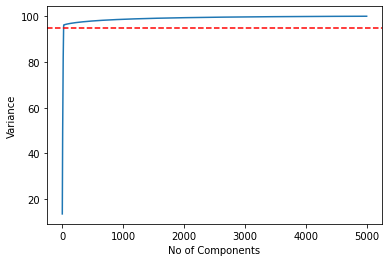

In [64]:
# Lets try PCA one final time
nforpcac(xrs)

In [65]:
modified_pcac(lrc,x_train,y_train,50)

(0.8518042891999487, 0.8939922836670955)

In [66]:
modified_pcac(lrc,x_train,y_train,150)

(0.8640041094131244, 0.9029597727480987)

In [67]:
modified_pcac(lrc,x_train,y_train,250)

(0.8670861692564531, 0.905089408528198)

In [68]:
modified_pcac(lrc,x_train,y_train,350)

(0.871709259021446, 0.9082728858690663)

In [69]:
modified_pcac(lrc,x_train,y_train,450)

(0.8613073070502119, 0.9014418689541888)

In [70]:
modified_pcac(lrc,x_train,y_train,600)

(0.8728650314626942, 0.9089236430542779)

In [71]:
# The best results are with 5000+ features

In [72]:
# Now, lets work on our test data set

In [81]:
test['cleaned']=test['Description'].apply(text_cleaning)
test['words in Description']=test['Description'].apply(num_words)
test['words in cleaned']=test['cleaned'].apply(num_words)
cleaned_test=test['cleaned'].values

In [87]:
# count=TfidfVectorizer(max_features=5000)
bow=count.transform(cleaned_test)
bow_feat=pd.DataFrame.sparse.from_spmatrix(bow)
bow_feat.columns=count.get_feature_names()
bow_1=pd.concat([test,bow_feat],axis=1)
bow_1.drop(['User_ID','Description','cleaned','words in Description','Browser_Used','Device_Used']
              ,axis=1,inplace=True)
# bow_1000['Browser_Used']=bow_1000['Browser_Used'].map({'Google Chrome':'Chrome','InternetExplorer':'IE', 'Internet Explorer':'IE', 'Mozilla Firefox':'Firefox',
#                                                  'Mozilla':'Firefox', 'Safari':'Safari','Opera':'Opera','Edge':'Edge','Chrome':'Chrome',
#                                             'Firefox':'Firefox','IE':'IE'})
# browser=pd.get_dummies(bow_1000['Browser_Used'],drop_first=True)
# bow_1000=pd.concat([browser,bow_1000],axis=1)
# device=pd.get_dummies(bow_1000['Device_Used'],drop_first=True)
# bow_1000=pd.concat([device,bow_1000],axis=1)
# bow_1000.drop(['Browser_Used','Device_Used'],axis=1,inplace=True)
bow_1.head()

,words in cleaned,pos,neg,aaa,abandon,ability,able,abound,abrupt,absence,absolute,absolutely,abundance,abundant,ac,accent,accept,acceptable,access,accessible,accident,accidentally,accomadating,accommodate,accommodation,accommodations,accomodate,accomodated,accomodating,accomodation,accomodations,accompany,accord,accordingly,account,accross,accurate,accuse,accustom,ace,...,wrong,ws,wtc,wyndham,xmas,xv,ya,yard,yards,yeah,year,years,yell,yellow,yes,yesterday,yet,ymca,yo,yoga,yoghurt,yogurt,yogurts,york,yorker,yorkers,yotel,young,younger,youth,yr,yrs,yuck,yum,yummy,zaza,zen,zero,zone,zoo
0,422,0.092,0.048,0.148677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,373,0.302,0.061,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.140385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,584,0.301,0.037,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.103527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,421,0.216,0.050,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,174,0.646,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
pred=lrc.predict(bow_1)

In [85]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
test['pos']=0
test['neg']=0
for i in range(len(test)):
    score = SentimentIntensityAnalyzer().polarity_scores(test['cleaned'].iloc[i])
    test['neg'].iloc[i]=score['neg']
    test['pos'].iloc[i]=score['pos']

In [86]:
test.head()

,User_ID,Description,Browser_Used,Device_Used,cleaned,words in Description,words in cleaned,pos,neg
0,id80132,Looking for a motel in close proximity to TV t...,Firefox,Mobile,look motel close proximity tv tap dr phil show...,676,422,0.092,0.048
1,id80133,Walking distance to Madison Square Garden and ...,InternetExplorer,Desktop,walk distance madison square garden penn subwa...,588,373,0.302,0.061
2,id80134,Visited Seattle on business. Spent - nights in...,IE,Tablet,visit seattle business spend nights vintage pa...,863,584,0.301,0.037
3,id80135,This hotel location is excellent and the rooms...,Edge,Mobile,hotel location excellent room clean suite one ...,778,421,0.216,0.050
4,id80136,This hotel is awesome I love the service Antho...,Mozilla,Mobile,hotel awesome love service anthony really grea...,255,174,0.646,0.000


In [90]:
pd.DataFrame(pred).to_csv('pred_for_sentiment')

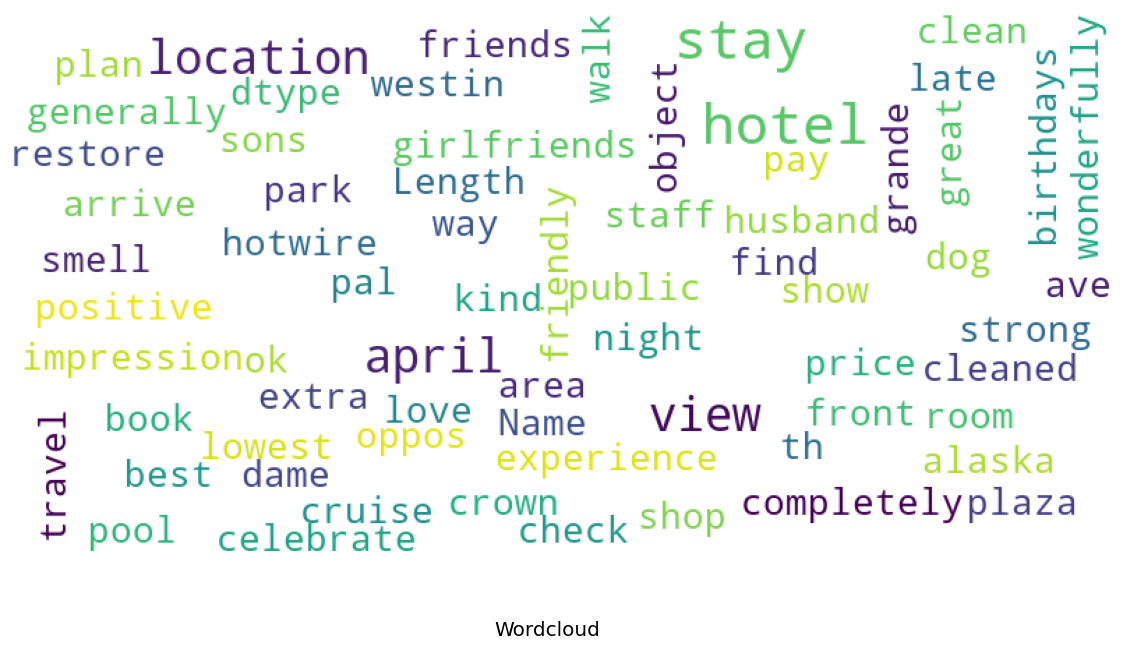

In [113]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def wordcloud(text, title = 'Wordcloud'):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 500,
        max_font_size = 20, 
        scale = 2,
        random_state = 42
    ).generate(str(text))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
wordcloud(train["cleaned"])

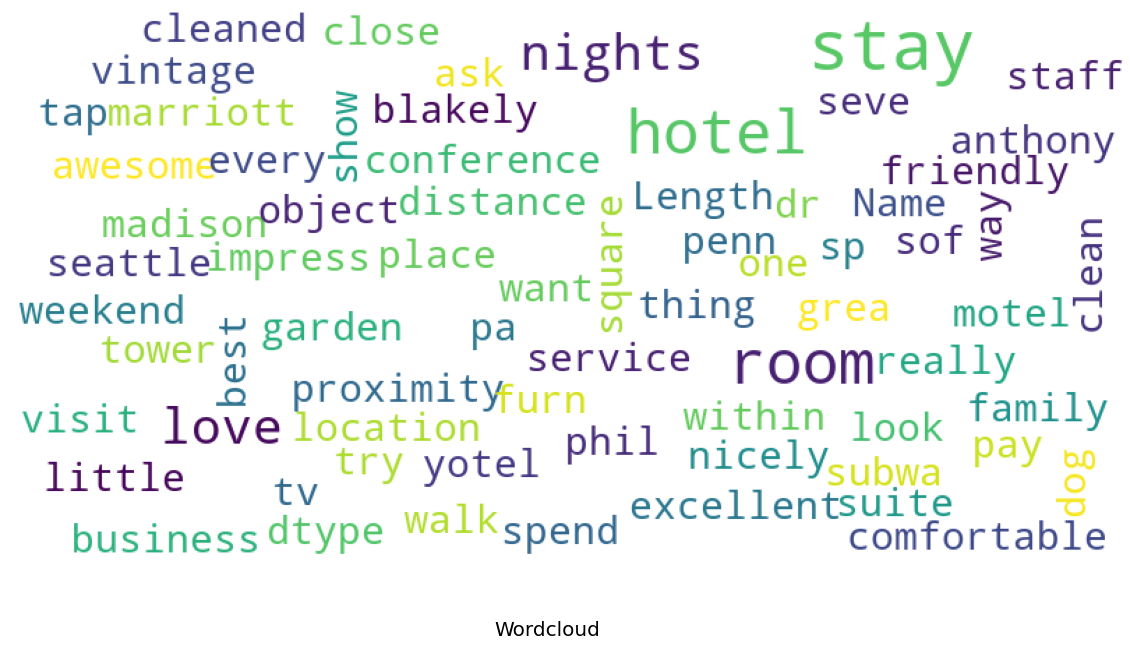

In [100]:
wordcloud(test["cleaned"])

In [101]:
# Let's review Top sentiments

In [104]:
top_pos_tr=train[['cleaned','pos']].sort_values(by='pos', ascending=False)[:100]
top_pos_tr.head()

,cleaned,pos
5568,nice clean calm friendly superb recommend defi...,1.000
21241,perfect location great value,0.911
12383,outstanding friendly service,0.878
1959,well room definitely nice breakfast good yeah,0.864
23693,nice hotel comfortable clean enjoy stay,0.857


In [105]:
top_neg_tr=train[['cleaned','neg']].sort_values(by='neg', ascending=False)[:100]
top_neg_tr.head()

,cleaned,neg
15681,stay doubt stay ramadas disappoint carpet dirty,0.669
37652,complain pay night park,0.661
32913,dirty smelly expensive awful awful awful put c...,0.634
31258,no hot water room small noisy uncomfortable,0.619
27147,nothing special place location not great inter...,0.595


In [106]:
top_pos_te=test[['cleaned','pos']].sort_values(by='pos', ascending=False)[:100]
top_pos_te.head()

,cleaned,pos
14018,great hotel good location great great great,0.906
14133,great value friendly courteous clean comfortab...,0.895
2849,love hotel friendliness staff helpful pleasant,0.869
19907,nice pretty room,0.857
27209,room nice comfortable staff friendly helpful o...,0.846


In [107]:
top_neg_te=test[['cleaned','neg']].sort_values(by='neg', ascending=False)[:100]
top_neg_te.head()

,cleaned,neg
17512,gross smelly disgust enough say,0.700
12249,disgust customer service dirty room,0.694
211,hotel need tear absolutely rediculous nasty na...,0.674
8752,dirty run dump north downtown dingy stinky rec...,0.605
28433,not sure best hotel visit recently clear worst...,0.577


In [108]:
text_top_pos=top_pos_tr['cleaned'].values

In [109]:
text_top_pos

array(['nice clean calm friendly superb recommend definitely',
       'perfect location great value', 'outstanding friendly service',
       'well room definitely nice breakfast good yeah',
       'nice hotel comfortable clean enjoy stay',
       'staff helpful friendly room clean comfortable',
       'surprise good price good location clean love staff nice',
       'excellent clean nice staff excellent view definitely recommend friends convenient shop',
       'beautiful hotel great location pure bliss love',
       'wonderful hotel staff friendly helpful hotel clean welcome',
       'room beautiful clean staff wonderful everyone friendly helpful love stay',
       'pleasant surprise hotel nicely restore well staff definitely stay',
       'super fab love great service especially cookies',
       'well worth money great staff helpful great location',
       'great service great location friendly helpful staff',
       'friendly helpful staff awesome room clean easy easy access ih',
  

In [110]:
text_top_neg=top_neg_tr['cleaned'].values
text_top_neg

array(['stay doubt stay ramadas disappoint carpet dirty',
       'complain pay night park',
       'dirty smelly expensive awful awful awful put chair door keep safe bad',
       'no hot water room small noisy uncomfortable',
       'nothing special place location not great interest walk metroing fine vehicles no complaints',
       'clean staff unprofessional upset awkward not hospitable',
       'terrible place service bad hotel staff rude leave stuff room lose come back night bad experience not stay hotel',
       'poor service room age no restaurant low season extremely noisy ac inpersonal staff breakfast age avoid unless no choice',
       'not recommend hotel worst enemy staff lack proper train not communicate well visitors consequentyly service abhorrent',
       'picture deceive compare real room room not well take care',
       'beware place old dirty walk carpet sock black dirt room bad shape mildew smell overwhelm',
       'bathrooms nasty room roach disgust keep luggage bed

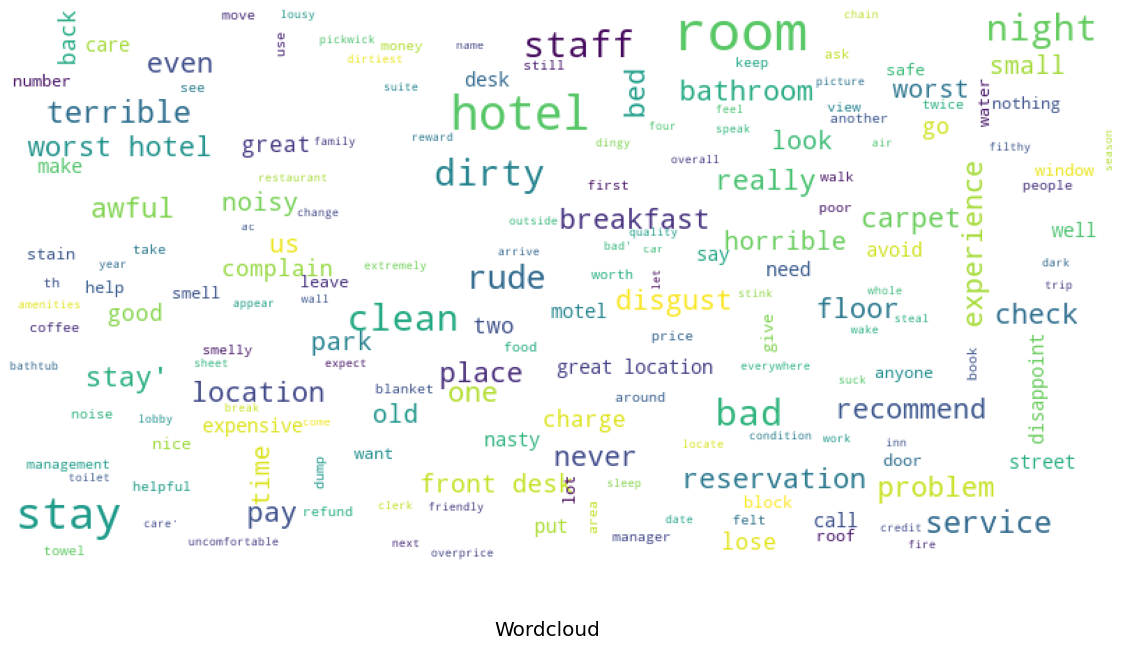

In [114]:
wordcloud(text_top_neg)

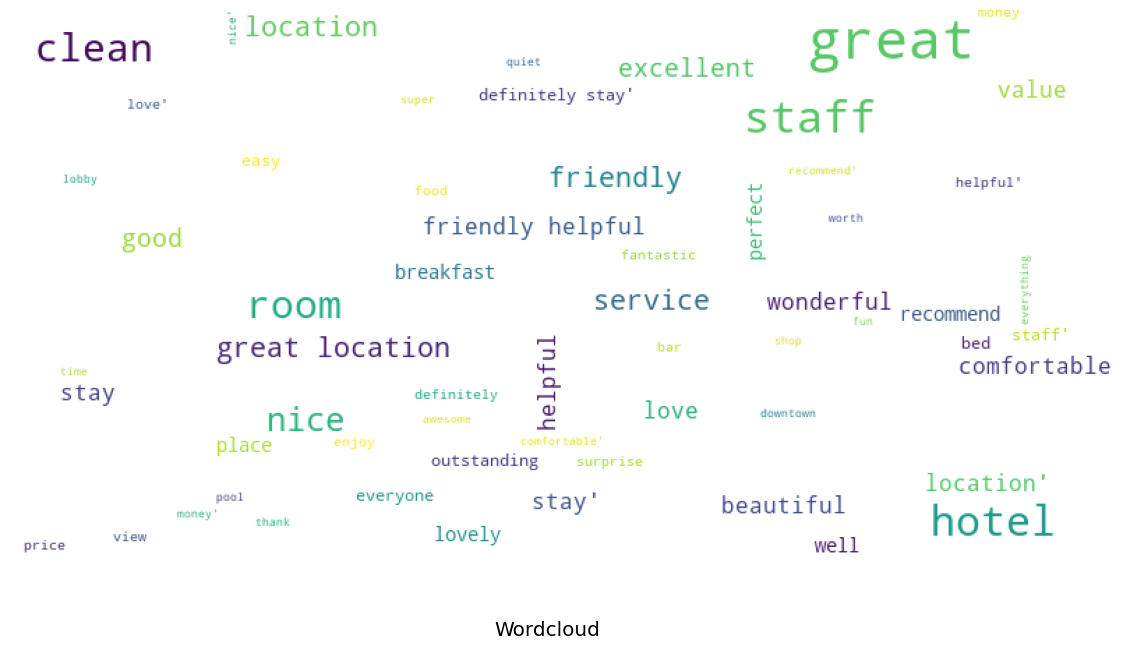

In [115]:
wordcloud(text_top_pos)